Transfer Learning

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os
import math
from tensorflow.keras import layers
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Bidirectional, LSTM
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import AUC, Accuracy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import rgb_to_grayscale
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, initializers
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1 , l2
from tensorflow.keras.models import Model
from tensorflow.keras.losses import KLDivergence
from IPython.display import display, HTML
from tensorflow.keras import backend as K
import random
from tensorflow.keras.models import clone_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import LearningRateScheduler
import platform


In [ ]:
DEBUG = True
MACHINE = platform.node()
THOMAS = 'laptom'
SEED = 42

tf.keras.utils.set_random_seed(SEED)

if DEBUG:
    print("seed is", SEED)


seed is 42


In [ ]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        try:
            image_path = os.path.join(path, file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (75, 75))
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {file} with OpenCV: {str(e)}")

    return images, labels


In [ ]:
# reset the sets
train = []
label_train = []
test = []
label_test = []


In [ ]:
# load our target data set: horses vs. humans
if MACHINE == THOMAS:
    HORSE_HUMAN_BASE = 'C:/Users/thoma/OneDrive/Dokumente/UNI/_Master/DL/2023-2024/dl23-assignment-3/project/horse-or-human'
else:
    HORSE_HUMAN_BASE = '/kaggle/input/horses-or-humans-dataset/horse-or-human'

HORSE_HUMAN_TRAIN = HORSE_HUMAN_BASE + '/train/'
HORSE_HUMAN_TEST = HORSE_HUMAN_BASE + '/validation/'

images, labels = load_images_from_path(HORSE_HUMAN_TRAIN + 'horses/', 0)

train += images
label_train += labels

images, labels = load_images_from_path(HORSE_HUMAN_TRAIN + 'humans/', 1)

train += images
label_train += labels

images, labels = load_images_from_path(HORSE_HUMAN_TEST + 'horses/', 0)

test += images
label_test += labels

images, labels = load_images_from_path(HORSE_HUMAN_TEST + 'humans/', 1)

test += images
label_test += labels


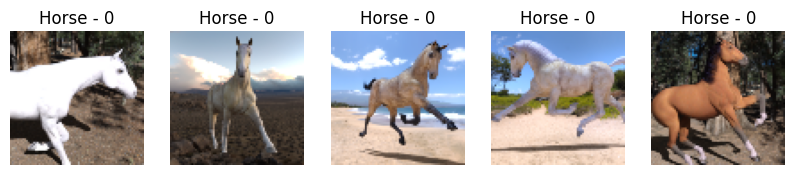

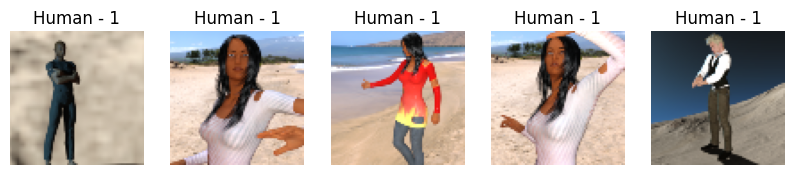

In [ ]:
def show_images(images, labels, class_name):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'{class_name} - {labels[i]}')
        plt.axis('off')
    plt.show()

# Display 5 samples from the training set for each class
horse_indices_train = np.where(np.array(label_train) == 0)[0][:5]
human_indices_train = np.where(np.array(label_train) == 1)[0][:5]

show_images(np.array(train)[horse_indices_train], np.array(label_train)[horse_indices_train], 'Horse')
show_images(np.array(train)[human_indices_train], np.array(label_train)[human_indices_train], 'Human')


In [ ]:
test, val, label_test, label_val = train_test_split(test, label_test, test_size=0.5, random_state=SEED)


In [ ]:
train = np.array(train)
label_train = np.array(label_train)
test = np.array(test)
label_test = np.array(label_test)
val = np.array(val)
label_val = np.array(label_val)


### Load two additional datasets for pretraining

We will pretrain a custom model. One will be trained on a "good" dataset in the sence that the data contained in that dataset is deemed similar to that of the target task. The other will be trained on a dissimilar dataset.

In [ ]:
Pre_train = []
Pre_label_train = []


In [ ]:
# load the similar dataset -> animals
if MACHINE == THOMAS:
    ANIMALS_BASE = 'C:/Users/thoma/OneDrive/Dokumente/UNI/_Master/DL/2023-2024/dl23-assignment-3/project/animals/raw-img/'
else:
    ANIMALS_BASE = '/kaggle/input/animals10/raw-img/'

images, labels = load_images_from_path(ANIMALS_BASE + 'cane/', 0)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'cavallo/', 1)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'elefante/', 2)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'farfalla/', 3)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'gallina/', 4)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'gatto/', 5)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'mucca/', 6)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'pecora/', 7)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'ragno/', 8)

Pre_train += images
Pre_label_train += labels

images, labels = load_images_from_path(ANIMALS_BASE + 'scoiattolo/', 9)

Pre_train += images
Pre_label_train += labels


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

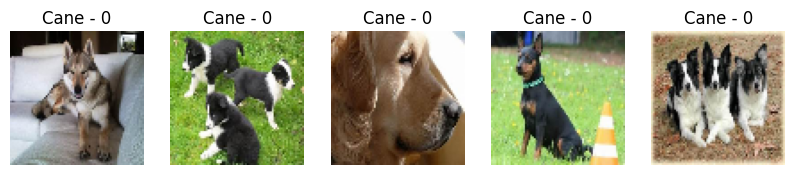

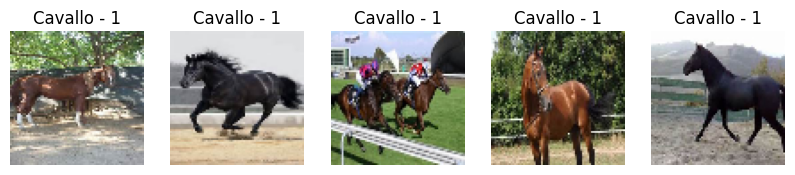

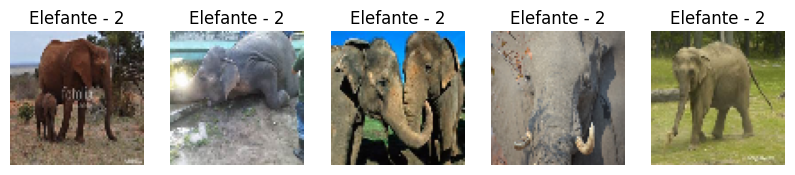

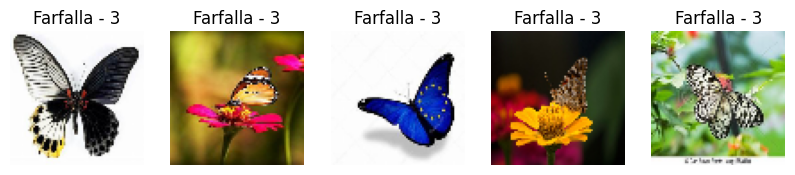

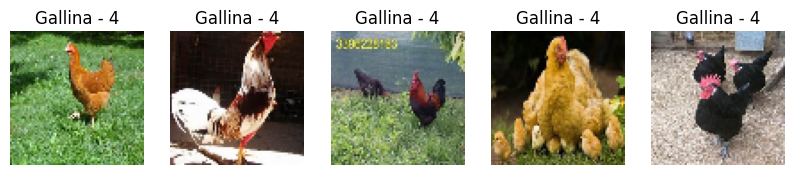

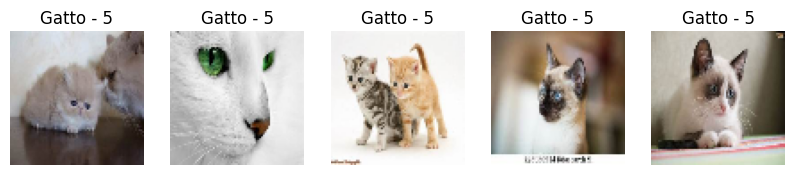

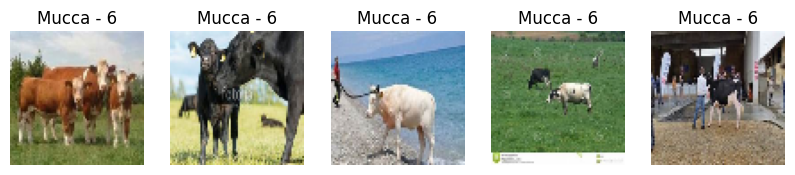

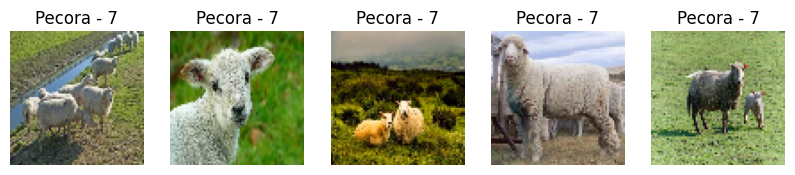

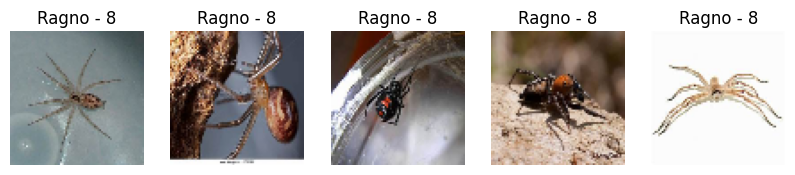

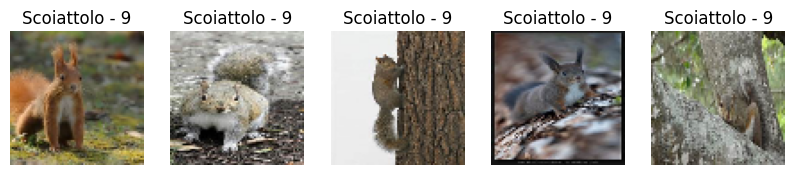

In [ ]:
for class_label in range(10):
    class_indices_train = np.where(np.array(Pre_label_train) == class_label)[0][:5]
    class_name = {0: 'Cane', 1: 'Cavallo', 2: 'Elefante', 3: 'Farfalla', 4: 'Gallina',
                  5: 'Gatto', 6: 'Mucca', 7: 'Pecora', 8: 'Ragno', 9: 'Scoiattolo'}[class_label]
    show_images(np.array(Pre_train)[class_indices_train], np.array(Pre_label_train)[class_indices_train], class_name)


In [ ]:
Pre_train = np.array(Pre_train)
Pre_label_train = to_categorical(Pre_label_train)


In [ ]:
Pre_train2 = []
Pre_label_train2 = []


In [ ]:
#Reichel: one thought. would it make sample the same number of examples from both the good and the bad dataset? right now the animals-dataset
#         has 26.000 examples while vehicles has 4.000. could making them the same size make them comparable better when we finetune? one
#         argument could be that it's no suprise that the good pretrained model on the animals-dataset performs better because it has much
#         more training data.
if MACHINE == THOMAS:
    VEHICLE_BASE = 'C:/Users/thoma/OneDrive/Dokumente/UNI/_Master/DL/2023-2024/dl23-assignment-3/project/vehicles/8-Objects-Training/'
else:
    VEHICLE_BASE = '/kaggle/input/vehiclestransport/8-Objects-Training/'

images, labels = load_images_from_path(VEHICLE_BASE + 'Airplanes/', 0)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Bikes/', 1)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Buses/', 2)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Cars/', 3)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Helicopters/', 4)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Ships/', 5)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Trains/', 6)

Pre_train2 += images
Pre_label_train2 += labels

images, labels = load_images_from_path(VEHICLE_BASE + 'Trucks/', 7)

Pre_train2 += images
Pre_label_train2 += labels


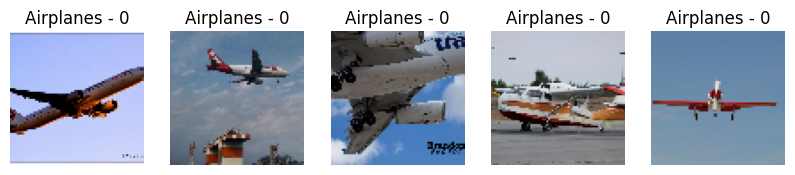

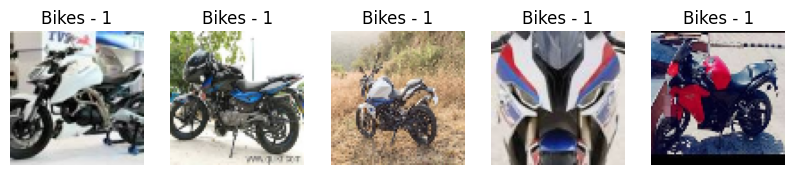

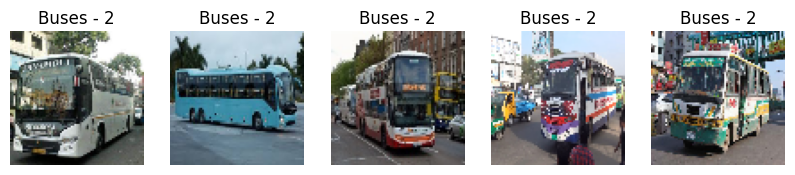

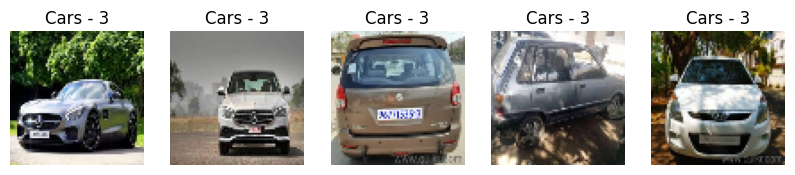

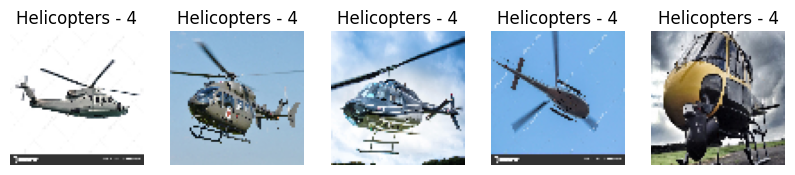

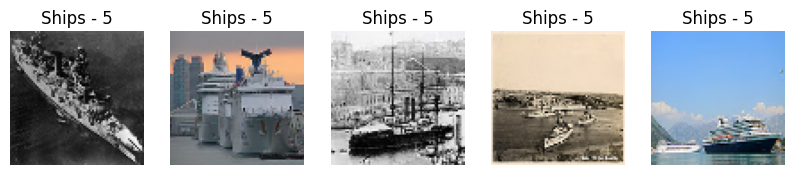

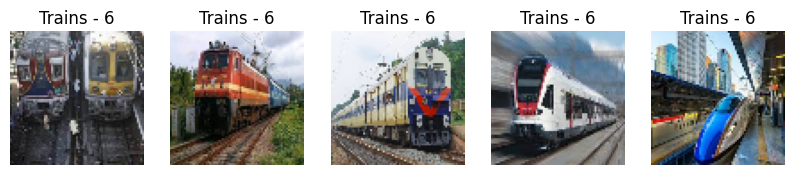

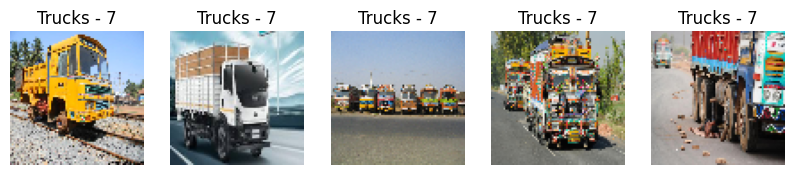

In [ ]:
class_labels = {'Airplanes': 0, 'Bikes': 1, 'Buses': 2, 'Cars': 3, 'Helicopters': 4, 'Ships': 5, 'Trains': 6, 'Trucks': 7}

for class_name, class_label in class_labels.items():
    class_indices_train = np.where(np.array(Pre_label_train2) == class_label)[0][:5]
    show_images(np.array(Pre_train2)[class_indices_train], np.array(Pre_label_train2)[class_indices_train], class_name)


In [ ]:
Pre_train2 = np.array(Pre_train2)
Pre_label_train2 = to_categorical(Pre_label_train2)


In [ ]:
#Reichel: early stopping with keeping best weights is actually alright but we need to take care of two things
#         * if early stopping is not triggered the best weights will not be restored. rather the ones of the last epoch will be kept:
#           https://medium.com/@doleron/never-use-restore-best-weights-true-with-earlystopping-754ba5f9b0c6
#         * somehow indicate in plots of training evolution where we stopped (also remember it for later training)
#         then we can increase the patience again
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
def lr_schedule(epoch):
    initial_lr = 0.001
    decay_factor = 0.5
    decay_steps = 10
    lr = initial_lr * (decay_factor ** (epoch // decay_steps))
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

# Building a Base Model To see it initial Accuracy

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 36, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dropout (Dropout)           (None, 18496)             0

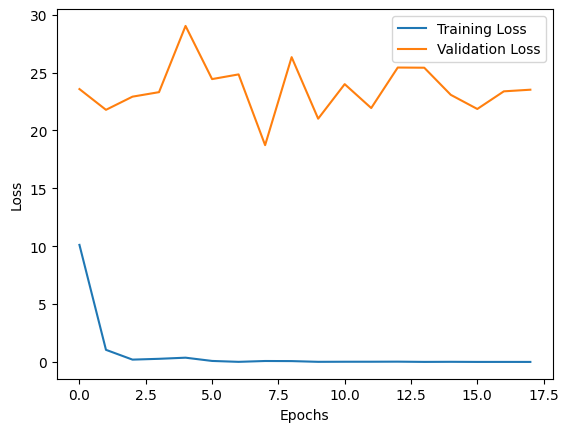

In [ ]:
model = models.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(75, 75, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
start_time = time.time()
history =  model.fit(train, label_train, epochs=100, batch_size=32, validation_data=(val,label_val), callbacks=[lr_scheduler,early_stop])
training_time = time.time() - start_time
print(f"Training Time: {training_time:.2f} seconds")

eval_result = model.evaluate(val, label_val)
print(f"Test Accuracy: {eval_result[1]*100:.2f}%")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# we are gonna train 4 models and use them as pretrined model on human vs horses dataset
* model 1 : trained on animals dataset of 10 classes with small architecture
* model 2 : trained on animals dataset of 10 classes with deeper architecture
* model 3 : trained on vehicles dataset of 8 classes with small architecture
* model 4 : trained on vehicles dataset of 8 classes with deeper architecture

In [ ]:
# create pretrained base model (shallow) on animals
def shallow_custom_architecture(name, num_classes):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1 if num_classes == 2 else num_classes, activation='sigmoid' if num_classes == 2 else 'softmax')
    ], name=name)

custom_pretrained_animals = shallow_custom_architecture(name="custom_pretrained_animal", num_classes=10)
custom_pretrained_animals.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

if DEBUG:
    custom_pretrained_animals.summary(show_trainable=True)

_ = custom_pretrained_animals.fit(Pre_train, Pre_label_train, epochs=100, batch_size=32, callbacks=[lr_scheduler])


Model: "custom_pretrained_animal"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_6 (Conv2D)           (None, 73, 73, 32)        896       Y          
                                                                            
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         Y          
 g2D)                                                                       
                                                                            
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     Y          
                                                                            
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)        0         Y          
 g2D)                                                                       
                                                                            
 flatten_1 (Flatten)         (None, 18496)

In [ ]:
# create pretrained base model (deep) on animals
#Reichel: 10 epochs probably not enough to converge. this architecture is pretty complicated plus it surely has a great capacity, but it takes looooong to train.
#         very slow training. might need to be optimized.
#         and for it's depth is has pretty bad performance, which is not expected. is the learning rate high enough?
#Reichel: what is the reason behind this architecture? I can see that it is using residual blocks but some architectural choices are not very apparent for me.
#         examples as comments below.
def create_advanced_architecture(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x) #Reichel: why add an activation layer here? this adds a 2nd activation between the 1st and 2nd block.
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x) #Reichel: is the activation missing here?

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x) #Reichel: why no dense layers? this is a big CNN without any dense layers after the convolutional layers.
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return models.Model(inputs, outputs)

# Create the advanced model
model2 = create_advanced_architecture((75, 75, 3), 10)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary(show_trainable=True)

# Train the model on the entire pre-training dataset
_ = model2.fit(Pre_train, Pre_label_train, epochs=100, batch_size=32, callbacks=[lr_scheduler])


Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 75, 75, 3)]          0         []                            Y          
                                                                                                             
 rescaling_1 (Rescaling)     (None, 75, 75, 3)            0         ['input_2[0][0]']             Y          
                                                                                                             
 conv2d_8 (Conv2D)           (None, 38, 38, 128)          3584      ['rescaling_1[0][0]']         Y          
                                                                                                             
 batch_normalization_8 (Bat  (None, 38, 38, 128)          512       ['conv2d_8[0][0]']            Y    

In [ ]:
# create pretrained base model (shallow) on vehicles
#Reichel: has really bad accuracy, the loss is best at epoch 1 and then keeps decreasing. the deep model too unfortunately. maybe improve architecture?
custom_pretrained_vehicles = shallow_custom_architecture(name="custom_pretrained_vehicles", num_classes=8)
custom_pretrained_vehicles.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

if DEBUG:
    custom_pretrained_vehicles.summary(show_trainable=True)

_ = custom_pretrained_vehicles.fit(Pre_train2, Pre_label_train2, epochs=100, batch_size=32, callbacks=[lr_scheduler])


Model: "custom_pretrained_vehicles"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_12 (Conv2D)          (None, 73, 73, 32)        896       Y          
                                                                            
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 32)        0         Y          
 ng2D)                                                                      
                                                                            
 conv2d_13 (Conv2D)          (None, 34, 34, 64)        18496     Y          
                                                                            
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 64)        0         Y          
 ng2D)                                                                      
                                                                            
 flatten_2 (Flatten)         (None, 1849

In [ ]:
# create pretrained base model (deep) on vehicles
#Reichel: can be merged with creation of model2
#Reichel: has accuracy of 0. this seems weird. more like a bug somewhere rather than "just" bad performance?
#Reichel: thought/discussion: bring both models to the same base accuracy at their own task?
def create_advanced_architecture(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return models.Model(inputs, outputs)

# Create the advanced model
model4 = create_advanced_architecture((75, 75, 3), 8)

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary(show_trainable=True)

# Train the model on the entire pre-training dataset
_ = model4.fit(Pre_train2, Pre_label_train2, epochs=100, batch_size=32, callbacks=[lr_scheduler])


Model: "model_2"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_3 (InputLayer)        [(None, 75, 75, 3)]          0         []                            Y          
                                                                                                             
 rescaling_2 (Rescaling)     (None, 75, 75, 3)            0         ['input_3[0][0]']             Y          
                                                                                                             
 conv2d_14 (Conv2D)          (None, 38, 38, 128)          3584      ['rescaling_2[0][0]']         Y          
                                                                                                             
 batch_normalization_16 (Ba  (None, 38, 38, 128)          512       ['conv2d_14[0][0]']           Y    

# Now We Are Gonna Pretrained Models with 3 different approaches

Approach 1: Keep the earlier convolutional layers fixed and only fine-tune the later layers. Implement this by setting the trainable parameter for the earlier layers to False during fine-tuning.

Approach 2: Only fine-tune the output layer. Freeze all other layers during training and only allow updates to the output layer.

Approach 3: Fine-tune all network weights. Allow updates to all layers during training.




In [ ]:
def reset_trainable(model, unfrozen_layers):
    for layer in model.layers[0].layers:
        layer.trainable = False
    for layer in model.layers[0].layers[-unfrozen_layers:]:
        layer.trainable = True

In [ ]:
def reseet_trainable(model):
    for layer in model.layers:
        layer.trainable = True

def print_layers(layers, level=0):
    for layer in layers:
        if hasattr(layer, 'layers'):
            print_layers(layer.layers, level + 1)
        else:
            print(level*2*" ", "[", layer.trainable, "]", layer.name)


In [ ]:
def fine_tune_model1(pretrained_model, model_name, train_data, train_labels, val_data, val_labels):
    results = []

    for approach in range(1, 4):
        model = models.clone_model(pretrained_model)
        model.set_weights(pretrained_model.get_weights())
        reseet_trainable(pretrained_model)

        if approach == 1:
            # Keep the earlier convolutional layers fixed and only fine-tune the later layers
            for layer in model.layers[:-3]:
                layer.trainable = False
        elif approach == 2:
            # Only fine-tune the output layer
            model.layers[-1].trainable = True
            for layer in model.layers[:-1]:
                layer.trainable = False
        elif approach == 3:
            # Fine-tune all of the network weights
            reseet_trainable(model)

        model.add(layers.Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train and evaluate the model
        start_time = time.time()
        history = model.fit(train_data, train_labels,  epochs=100, batch_size=32, validation_data=(val_data, val_labels), callbacks=[lr_scheduler,early_stop])
        end_time = time.time()
        training_time = end_time - start_time
        loss, accuracy = model.evaluate(val_data, val_labels)

        # Print model summary
        print(f"\n{model_name} Approach {approach} Model Summary:")
        model.summary()

        print(f"\n{model_name} Approach {approach} Test Loss and Accuracy:")
        print(f"Validation Loss: {loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Training Time: {training_time} seconds")

        # Append results
        results.append({
            "Model Name": f"{model_name}_approach{approach}",
            "Time for Training": training_time,
            "Parameters Numbers (Fixed, Trainable)": (
                np.sum([np.prod(w.shape) for layer in model.layers if not layer.trainable for w in layer.get_weights()]),
                np.sum([np.prod(w.shape) for layer in model.layers if layer.trainable for w in layer.get_weights()])
            ),
            "Validation Loss": loss,
            "Validation Accuracy": accuracy,
            "History": history,
            "Model Architecture": model.to_json(),
            "Fine-tuning Approach": approach
        })

    return results

In [ ]:
def fine_tune_model2(pretrained_model, model_name, train_data, train_labels, val_data, val_labels, num_classes=2):
    results = []

    for approach in range(1, 4):
        model = models.clone_model(pretrained_model)
        model.set_weights(pretrained_model.get_weights())
        reseet_trainable(pretrained_model)

        if approach == 1:
            # Keep the earlier convolutional layers fixed and only fine-tune the later layers
            for layer in model.layers[:-6]:
                layer.trainable = False

            x = model.layers[-2].output
            x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output
            model = models.Model(inputs=model.input, outputs=x)


        elif approach == 2:
            # Only fine-tune the output layer
            model.layers[-1].trainable = True
            for layer in model.layers[:-1]:
                layer.trainable = False
            x = model.layers[-2].output
            x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output
            model = models.Model(inputs=model.input, outputs=x)

        elif approach == 3:
            # Fine-tune all of the network weights
            x = model.layers[-2].output
            x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output
            model = models.Model(inputs=model.input, outputs=x)

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train and evaluate the model
        start_time = time.time()
        history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(val_data, val_labels), callbacks=[lr_scheduler,early_stop])
        end_time = time.time()
        training_time = end_time - start_time
        loss, accuracy = model.evaluate(val_data, val_labels)

        # Print model summary
        print(f"\n{model_name} Approach {approach} Model Summary:")
        model.summary()

        print(f"\n{model_name} Approach {approach} Test Loss and Accuracy:")
        print(f"Validation Loss: {loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Training Time: {training_time} seconds")

        # Plot training and validation loss
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} Approach {approach}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Append results
        results.append({
            "Model Name": f"{model_name}_approach{approach}",
            "Time for Training": training_time,
            "Parameters Numbers (Fixed, Trainable)": (np.sum([np.prod(w.shape) for layer in model.layers if hasattr(layer, 'trainable') and not layer.trainable for w in layer.get_weights()]),
                                          np.sum([np.prod(w.shape) for layer in model.layers if hasattr(layer, 'trainable') and layer.trainable for w in layer.get_weights()])),

            "Validation Loss": loss,
            "Validation Accuracy": accuracy,
            "History": history
        })

    return results

In [ ]:
def fine_tune_model(pretrained_model, model_name, train_data, train_labels, val_data, val_labels):
    results = []
    trainable_layer_counts = []
    val_accuracies = []
    approach_histories = []
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))


    for approach in range(1, 4):

        model = models.clone_model(pretrained_model)
        model.set_weights(pretrained_model.get_weights())
        reseet_trainable(pretrained_model)

        if approach == 1:
            # Keep the earlier convolutional layers fixed and only fine-tune the later layers
            model = Sequential([
                pretrained_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            # Freeze the earlier layers
            for layer in model.layers[0].layers[:-10]:
                layer.trainable = False
        elif approach == 2:
            # Only fine-tune the output layer
            model = Sequential([
                pretrained_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(1, activation='sigmoid')
            ])
            # Freeze all layers except the output layer
            for layer in pretrained_model.layers[:-1]:
                layer.trainable = False
        elif approach == 3:
            # Fine-tune all of the network weights
            model = Sequential([
                pretrained_model,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dense(1, activation='sigmoid')
            ])

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train and evaluate the model
        start_time = time.time()
        history = model.fit(train_data, train_labels,  epochs=100, batch_size=32, validation_data=(val_data, val_labels), callbacks=[lr_scheduler,early_stop])
        end_time = time.time()
        training_time = end_time - start_time
        loss, accuracy = model.evaluate(val_data, val_labels)


        trainable_layers = sum([1 for layer in model.layers[0].layers if layer.trainable])
        trainable_layer_counts.append(trainable_layers)
        val_accuracies.append(accuracy)
        approach_histories.append(history)

        # Print model summary
        print(f"\n{model_name} Approach {approach} Model Summary:")
        model.summary()

        print(f"\n{model_name} Approach {approach} Test Loss and Accuracy:")
        print(f"Validation Loss: {loss}")
        print(f"Validation Accuracy: {accuracy}")

        # Append results
        results.append({
            "Model Name": f"{model_name}_approach{approach}",
            "Time for Training": training_time,
            "Parameters Numbers (Fixed, Trainable)": (np.sum([np.prod(w.shape) for layer in model.layers[0].layers if not layer.trainable for w in layer.get_weights()]),
                                          np.sum([np.prod(w.shape) for layer in model.layers[0].layers if layer.trainable for w in layer.get_weights()])),


            "Validation Loss": loss,
            "Validation Accuracy": accuracy,
            "History": history
        })

    # Plot validation accuracy over epochs for each approach (outside the loop)
    for i, approach in enumerate(range(1, 4)):
        axs[0].plot(trainable_layer_counts, val_accuracies, marker='o', label=f'{model_name} Curve')

    axs[0].set_title(f'Validation Accuracy vs Trainable Layers ({model_name})')
    axs[0].set_xlabel('Number of Trainable Layers')
    axs[0].set_ylabel('Validation Accuracy')
    axs[0].legend()

    # Plot validation accuracy over epochs for each approach
    for i, approach in enumerate(range(1, 4)):
        axs[1].plot(approach_histories[i].history['val_accuracy'], label=f'Approach {approach}')

    axs[1].set_title(f'Validation Accuracy over Epochs ({model_name})')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].legend()

    # Annotate each approach in the second subplot
    for i, approach in enumerate(range(1, 4)):
        last_epoch_val_acc = approach_histories[i].history['val_accuracy'][-1]
        axs[1].annotate(f'Approach {approach} ({last_epoch_val_acc:.2f})',
                        xy=(len(approach_histories[i].history['val_accuracy']), last_epoch_val_acc),
                        xytext=(-20, 10),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"))

    plt.tight_layout()
    plt.show()

    return results

### Incremental finetuning

here we incrementally finetune more layers of our custom pretrained models and plot the accuracies against the trained layers to see the evolution.

In [ ]:
def calc_number_parameters(model):
    trainable_parameters = np.sum([np.prod(weights.get_shape()) for weights in model.trainable_weights])
    fixed_parameters = np.sum([np.prod(weights.get_shape()) for weights in model.non_trainable_weights])
    return int(trainable_parameters), int(fixed_parameters)

def calc_number_trainable_layers(model):
    trainable_layers = 0
    for layer in model.layers:
        if layer.trainable == True:
            trainable_layers = trainable_layers + 1
    return trainable_layers

def clone_model(model, new_name):
    clone = tf.keras.models.clone_model(model)
    clone._name = new_name
    clone.set_weights(model.get_weights())
    return clone

def unfreeze_layers_from_end(model, n):
    for layer in model.layers[-n:]:
        layer.trainable = True

def get_binary_classifier(model, name):
    return models.Sequential([
        *model.layers[:-1],
        layers.Dense(1, activation='sigmoid')
    ], name=name)

def finetune_incrementally(pretrained_model):
    finetuned_models = [pretrained_model]
    training_data = []
    model_data = []

    for i in range(1, len(pretrained_model.layers) + 1):
        clone = clone_model(pretrained_model, "approach_" + str(i))
        unfreeze_layers_from_end(clone, i)
        clone.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        finetuned_models.append(clone)

    for model in finetuned_models:
        if DEBUG:
            model.summary(show_trainable=True)

        start_time = time.time()
        training = model.fit(train, label_train, epochs=100, batch_size=32, validation_data=(val, label_val), callbacks=[early_stop], verbose=DEBUG)
        training_time = time.time() - start_time

        loss, accuracy = model.evaluate(val, label_val, verbose=DEBUG)

        trainable_layers = calc_number_trainable_layers(model)
        trainable_params, untrainable_params = calc_number_parameters(model)
        percentage_trainable = round(trainable_params * 100 / (trainable_params + untrainable_params), 2)

        if DEBUG:
            print(model.name, loss, accuracy)

        training_data.append(training)
        model_data.append(
            [model.name, trainable_layers, trainable_params, untrainable_params, percentage_trainable,
            training_time, len(training.history['val_loss']), loss, accuracy])

    results = pd.DataFrame(
        model_data,
        columns=['model', 'trainable layers', 'trainable parameters', 'untrainable parameters', 'percentage trainable',
                'training time', 'epochs', 'validation loss', 'validation accuracy'])

    return finetuned_models, results, training_data


In [ ]:
# finetune good model
finetune_base_animals = get_binary_classifier(custom_pretrained_animals, "finetune_base_animals")
finetune_base_animals.trainable = False
finetune_base_animals.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

animals_finetuned_models, animals_finetuning_results, animals_finetuned_training_data = finetune_incrementally(finetune_base_animals)
display(animals_finetuning_results)


Model: "finetune_base_animals"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_6 (Conv2D)           (None, 73, 73, 32)        896       N          
                                                                            
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 32)        0         N          
 g2D)                                                                       
                                                                            
 conv2d_7 (Conv2D)           (None, 34, 34, 64)        18496     N          
                                                                            
 max_pooling2d_6 (MaxPoolin  (None, 17, 17, 64)        0         N          
 g2D)                                                                       
                                                                            
 flatten_1 (Flatten)         (None, 18496)   

model  trainable layers  trainable parameters  \
0  finetune_base_animals                 0                     0   
1             approach_1                 1                    65   
2             approach_2                 2                  8321   
3             approach_3                 3                 41217   
4             approach_4                 4               4776449   
5             approach_5                 5               4776449   
6             approach_6                 6               4776449   
7             approach_7                 7               4794945   
8             approach_8                 8               4794945   
9             approach_9                 9               4795841   

   untrainable parameters  percentage trainable  training time  epochs  \
0                 4795841                  0.00       1.991817      11   
1                 4795776                  0.00       2.381592      11   
2                 4787520                  0.17       2.729473      11   
3                 4754624                  0.86       3.055097      11   
4                   19392                 99.60       3.456321      11   
5                   19392                 99.60       3.746570      11   
6                   19392                 99.60       3.447542      11   
7                     896                 99.98       3.950815      11   
8                     896                 99.98       4.077510      11   
9                       0                100.00       4.622534      11   

   validation loss  validation accuracy  
0         0.693147              0.53125  
1         0.693302              0.46875  
2         0.693302              0.46875  
3         0.693302              0.46875  
4         0.693302              0.46875  
5         0.693302              0.46875  
6         0.693302              0.46875  
7         0.693302              0.46875  
8         0.693302              0.46875  
9         0.693302              0.46875

In [ ]:
# finetune bad model
finetune_base_vehicles = get_binary_classifier(custom_pretrained_vehicles, "finetune_base_vehicles")
finetune_base_vehicles.trainable = False
finetune_base_vehicles.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vehicles_finetuned_models, vehicles_finetuning_results, vehicles_finetuned_training_data = finetune_incrementally(finetune_base_vehicles)
display(vehicles_finetuning_results)


Model: "finetune_base_vehicles"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv2d_12 (Conv2D)          (None, 73, 73, 32)        896       N          
                                                                            
 max_pooling2d_10 (MaxPooli  (None, 36, 36, 32)        0         N          
 ng2D)                                                                      
                                                                            
 conv2d_13 (Conv2D)          (None, 34, 34, 64)        18496     N          
                                                                            
 max_pooling2d_11 (MaxPooli  (None, 17, 17, 64)        0         N          
 ng2D)                                                                      
                                                                            
 flatten_2 (Flatten)         (None, 18496)  

model  trainable layers  trainable parameters  \
0  finetune_base_vehicles                 0                     0   
1              approach_1                 1                    65   
2              approach_2                 2                  8321   
3              approach_3                 3                 41217   
4              approach_4                 4               4776449   
5              approach_5                 5               4776449   
6              approach_6                 6               4776449   
7              approach_7                 7               4794945   
8              approach_8                 8               4794945   
9              approach_9                 9               4795841   

   untrainable parameters  percentage trainable  training time  epochs  \
0                 4795841                  0.00       1.953475      11   
1                 4795776                  0.00       5.389350      32   
2                 4787520                  0.17       3.987081      19   
3                 4754624                  0.86       4.539059      16   
4                   19392                 99.60       3.963099      14   
5                   19392                 99.60       3.964760      14   
6                   19392                 99.60       3.930679      14   
7                     896                 99.98       4.352540      13   
8                     896                 99.98       4.032395      11   
9                       0                100.00       4.681356      11   

   validation loss  validation accuracy  
0         3.532999             0.546875  
1         0.900497             0.632812  
2         1.315659             0.617188  
3         0.973074             0.671875  
4         4.308800             0.859375  
5         4.308800             0.859375  
6         4.308800             0.859375  
7         5.056686             0.859375  
8         6.917213             0.773438  
9         1.201413             0.835938

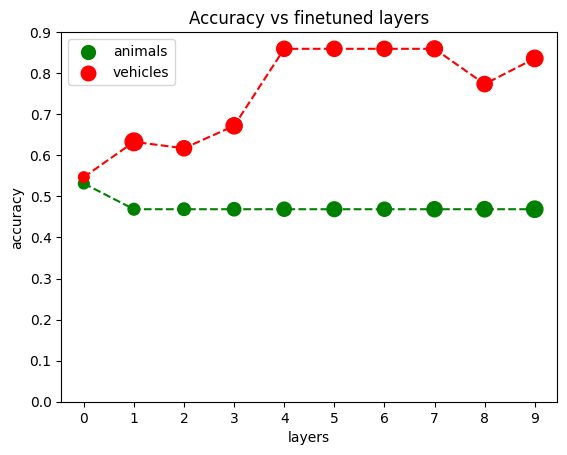

In [ ]:
def incremental_accuracy_plot(results, names, colors):

    for i, result in enumerate(results):
        color = colors[i % len(results[0])]

        plt.scatter(
            result["trainable layers"],
            result["validation accuracy"],
            color=color,
            s=result["training time"] * 30,
            label=names[i])
        plt.plot(
            result["trainable layers"],
            result["validation accuracy"],
            color=color,
            linestyle='--')

    plt.title('Accuracy vs finetuned layers')
    plt.xlabel('layers')
    plt.xticks(np.arange(0, len(results[0])))
    plt.ylabel('accuracy')
    plt.legend()
    _ = plt.yticks(np.arange(0, 1, step=0.1))


incremental_accuracy_plot(
    [animals_finetuning_results, vehicles_finetuning_results],
    ["animals", "vehicles"],
    ['g', 'r'])


# VGG16
## Structure
- VGG16 (Visual Geometry Group 16) is a convolutional neural network architecture proposed by the Visual Geometry Group at Oxford.
- It consists of 16 weight layers, including 13 convolutional layers and 3 fully connected layers.
- All convolutional layers use small 3x3 filters with a stride of 1 and 'same' padding.
- It follows a straightforward and uniform architecture, making it easy to understand and implement.

## Depth
- VGG16 has a depth of 16 layers, which was considered deep at the time of its proposal.

## Why Choose It
- The simplicity and uniformity of the architecture make it easy to understand and implement.
- It performed well in image classification tasks, especially in the ImageNet Large Scale Visual Recognition Challenge.

## Trained On
- VGG16 was initially trained on the ImageNet dataset, which consists of millions of labeled images across thousands of categories.

## Limitations
- VGG16 has a large number of parameters, making it computationally expensive and memory-intensive.
- It lacks skip connections, which can hinder its ability to capture hierarchical features effectively.
- Prone to overfitting on smaller datasets due to its large number of parameters.

# ResNet50
## Structure
- ResNet50 (Residual Network 50) is a variant of the ResNet architecture proposed by Microsoft Research.
- It introduces the concept of residual learning, where each building block learns the residual with respect to the input.
- It consists of 50 layers, primarily using 3x3 convolutional layers with skip connections.

## Depth
- ResNet50 has a depth of 50 layers, making it deeper than VGG16.

## Why Choose It
- The introduction of skip connections helps in mitigating the vanishing gradient problem, allowing for the training of very deep networks.
- Residual learning makes it easier to train deep networks by enabling the flow of gradients through the network.

## Trained On
- Like VGG16, ResNet50 is typically trained on large datasets such as ImageNet.

## Limitations
- Although skip connections address the vanishing gradient problem, very deep networks can still face challenges during training, such as the exploding gradient problem.

# MobileNetV2
## Structure
- MobileNetV2 is designed specifically for mobile and edge devices, aiming for efficiency and reduced computational complexity.
- It utilizes depthwise separable convolutions, which are factorized into depthwise convolutions followed by pointwise convolutions.

## Depth
- MobileNetV2 has a moderate depth, typically around 53 layers.

## Why Choose It
- MobileNetV2 is optimized for mobile devices with limited computational resources.
- Depthwise separable convolutions reduce the number of parameters and computations, making it more efficient for real-time applications on mobile devices.

## Trained On
- MobileNetV2 is often trained on datasets similar to VGG16 and ResNet50, such as ImageNet.

## Limitations
- While efficient, MobileNetV2 may not perform as well as deeper architectures like ResNet50 on complex tasks requiring very deep feature hierarchies.
- It might not be the best choice for tasks where high accuracy and large model capacity are critical.


In [ ]:
# load the pretrained Keras models
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
base_model4 = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
train_ds = preprocess_input(train)
test_ds = preprocess_input(test)
val_ds = preprocess_input(val)


Epoch 1/100
33/33 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6941 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6941 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6944 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6945 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5131 - val_loss: 0.6945 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6945 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.

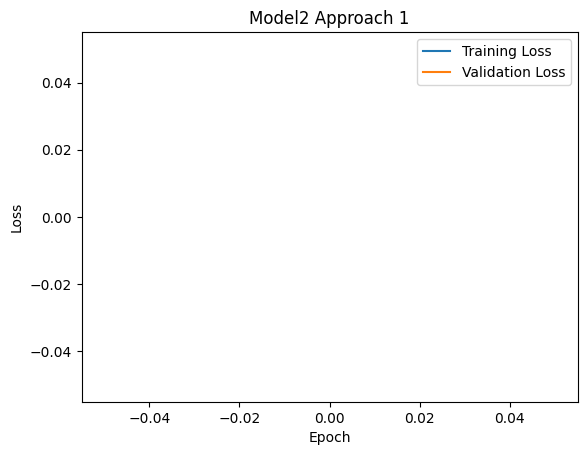

Epoch 1/100
33/33 [==============================] - 2s 40ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - loss: nan - accuracy: 0.4869 - val_los

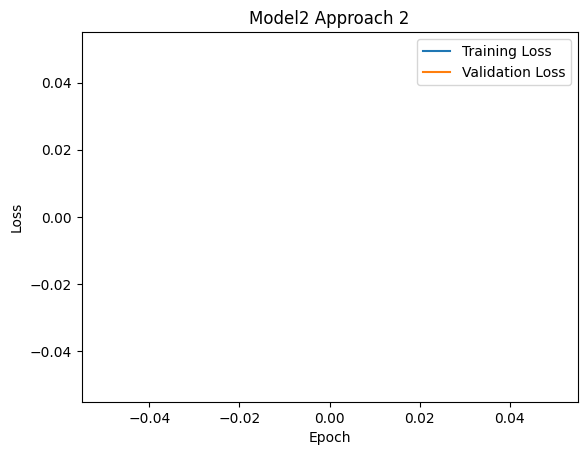

Epoch 1/100
33/33 [==============================] - 9s 47ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_loss: nan - val_accuracy: 0.5312 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - loss: nan - accuracy: 0.4869 - val_los

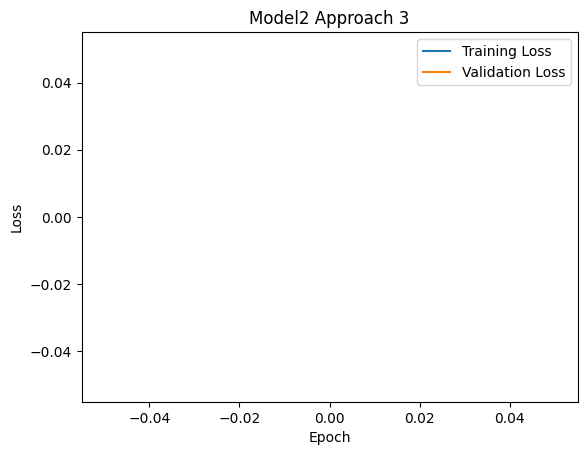

Epoch 1/100
33/33 [==============================] - 1s 11ms/step - loss: 0.7130 - accuracy: 0.4206 - val_loss: 0.7105 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.4878 - val_loss: 0.7029 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.5131 - val_loss: 0.7010 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6562 - accuracy: 0.5998 - val_loss: 0.6981 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6486 - accuracy: 0.6660 - val_loss: 0.6940 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.6435 - accuracy: 0.6884 - val_loss: 0.6934 - val_accuracy: 0.5703 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 0.

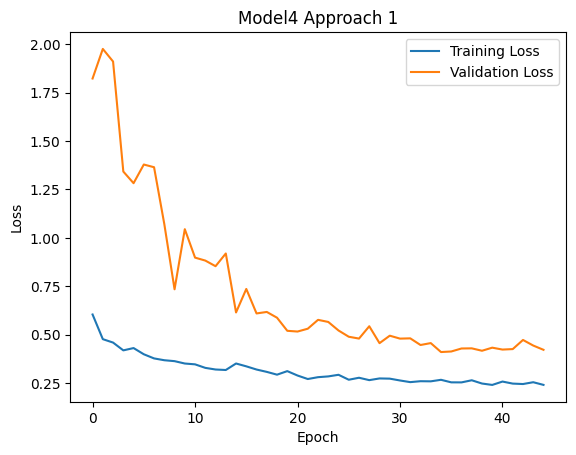

Epoch 1/100
33/33 [==============================] - 2s 25ms/step - loss: 0.6901 - accuracy: 0.5404 - val_loss: 0.7698 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6718 - accuracy: 0.5998 - val_loss: 0.8230 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6530 - accuracy: 0.6534 - val_loss: 0.8484 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6647 - accuracy: 0.6232 - val_loss: 0.8751 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6432 - accuracy: 0.6602 - val_loss: 0.8982 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 0.6381 - accuracy: 0.6563 - val_loss: 1.0012 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 14ms/step - lo

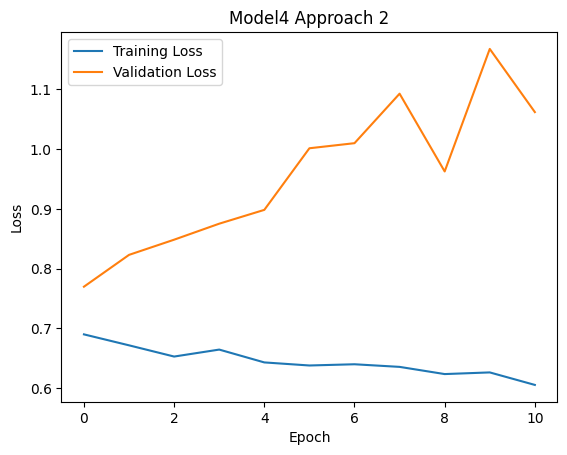

Epoch 1/100
33/33 [==============================] - 9s 48ms/step - loss: 0.5618 - accuracy: 0.6991 - val_loss: 0.6185 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 36ms/step - loss: 0.2537 - accuracy: 0.8929 - val_loss: 2.3826 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 36ms/step - loss: 0.1932 - accuracy: 0.9221 - val_loss: 2.1456 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 36ms/step - loss: 0.1010 - accuracy: 0.9640 - val_loss: 2.2336 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 36ms/step - loss: 0.1293 - accuracy: 0.9503 - val_loss: 0.4988 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 36ms/step - loss: 0.1041 - accuracy: 0.9630 - val_loss: 1.1663 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - lo

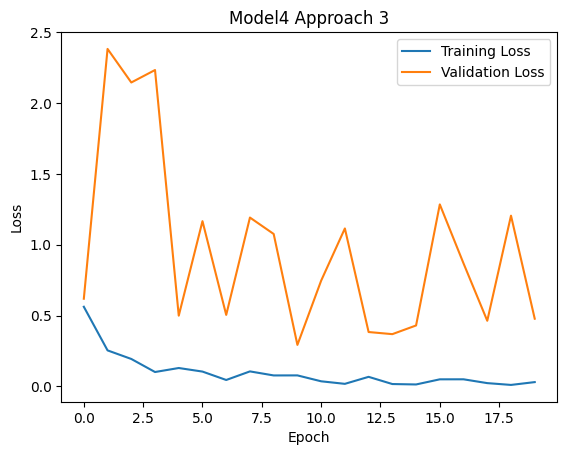

In [ ]:
results1 = fine_tune_model1(custom_pretrained_animals, "Model1", train, label_train, val, label_val)
results2 = fine_tune_model2(model2, "Model2", train, label_train, val, label_val)
results3 = fine_tune_model1(custom_pretrained_vehicles, "Model3", train, label_train, val, label_val)
results4 = fine_tune_model2(model4, "Model4", train, label_train, val, label_val)


Epoch 1/100
33/33 [==============================] - 7s 53ms/step - loss: 0.3155 - accuracy: 0.8656 - val_loss: 6.1846 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 0.1007 - accuracy: 0.9601 - val_loss: 6.3105 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0653 - accuracy: 0.9757 - val_loss: 5.5981 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0366 - accuracy: 0.9883 - val_loss: 0.9893 - val_accuracy: 0.6641 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 0s 11ms/step - loss: 0.1159 - accuracy: 0.9718 - val_loss: 5.2078 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0431 - accuracy: 0.9854 - val_loss: 6.6419 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - lo

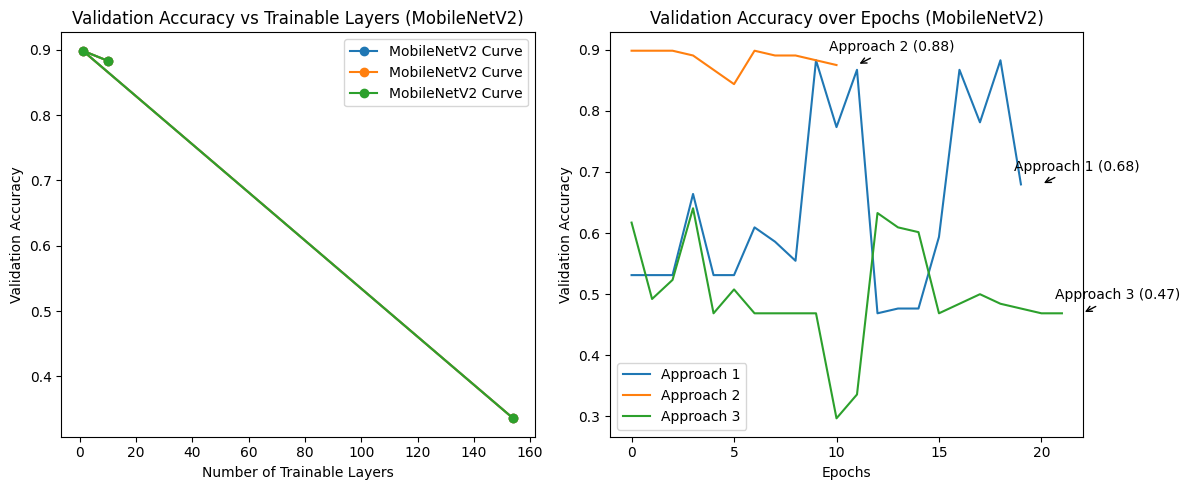

Epoch 1/100
33/33 [==============================] - 8s 74ms/step - loss: 0.0789 - accuracy: 0.9669 - val_loss: 8.4140 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 14.6330 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0145 - accuracy: 0.9961 - val_loss: 5.1709 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0018 - accuracy: 0.9990 - val_loss: 2.1094 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 24ms/step - loss: 3.9048e-04 - accuracy: 1.0000 - val_loss: 1.1843 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 24ms/step - loss: 6.0065e-05 - accuracy: 1.0000 - val_loss: 0.9595 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 1s 21ms/

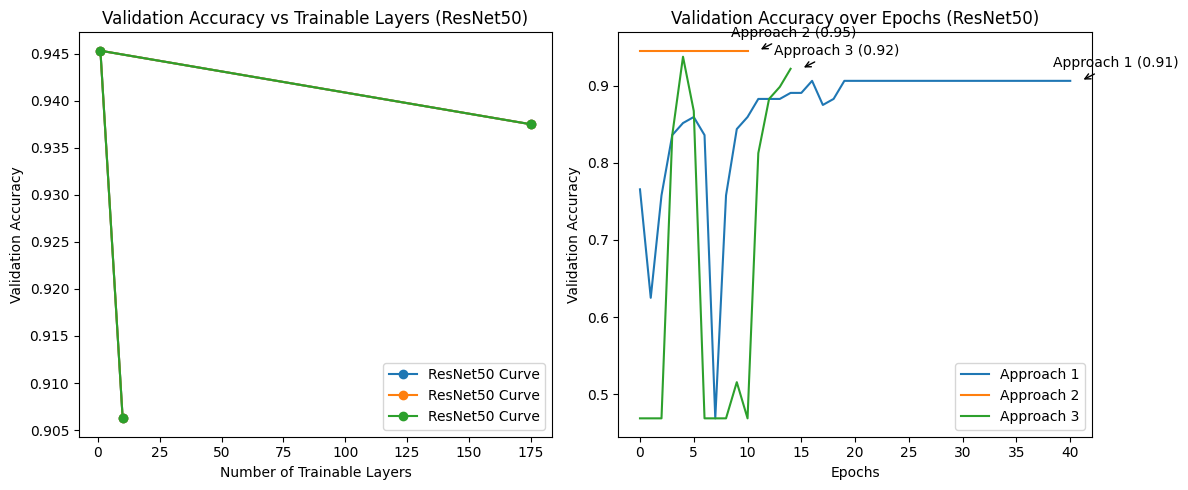

Epoch 1/100
33/33 [==============================] - 5s 43ms/step - loss: 366284.0000 - accuracy: 0.5209 - val_loss: 0.6641 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 26ms/step - loss: 252024704.0000 - accuracy: 0.5287 - val_loss: 9.2914 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 26ms/step - loss: 65785475072.0000 - accuracy: 0.5209 - val_loss: 81.0134 - val_accuracy: 0.5859 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 3650835712.0000 - accuracy: 0.5239 - val_loss: 85484.1562 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 2959131017216.0000 - accuracy: 0.5209 - val_loss: 6174.5605 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 119762886656.0000 - accuracy: 0.5560 - val_loss: 188562.9219 - val_accuracy: 0.6250 - lr: 0.0010
Ep

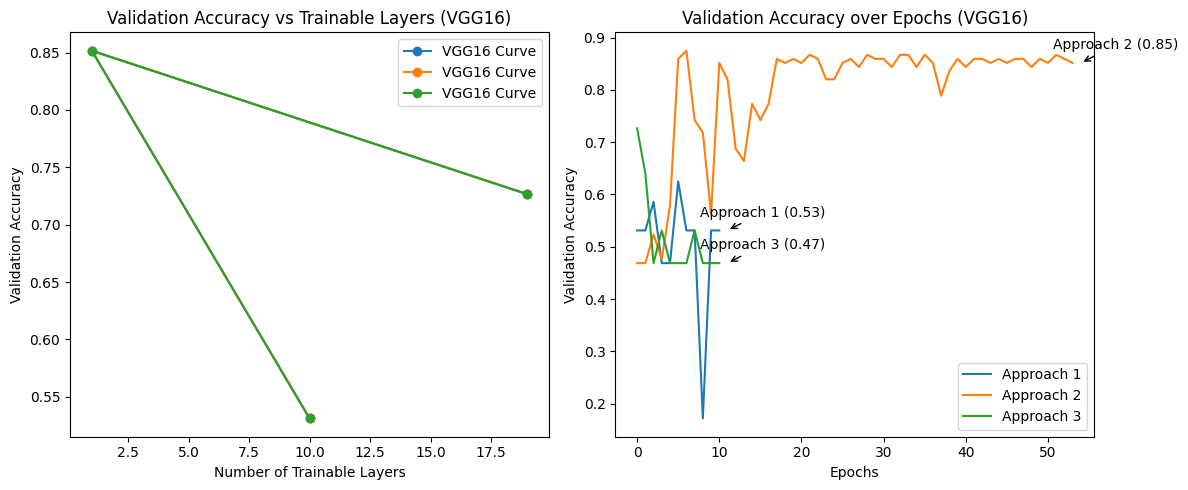

Epoch 1/100
33/33 [==============================] - 9s 85ms/step - loss: 17.6230 - accuracy: 0.6670 - val_loss: 3.8053 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 22ms/step - loss: 1.4045 - accuracy: 0.8296 - val_loss: 3.4916 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 23ms/step - loss: 1.2025 - accuracy: 0.8101 - val_loss: 3.0584 - val_accuracy: 0.8047 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 23ms/step - loss: 0.7669 - accuracy: 0.8715 - val_loss: 1.7772 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 0.3847 - accuracy: 0.9241 - val_loss: 1.8004 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 0.2476 - accuracy: 0.9279 - val_loss: 1.9612 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 7/100
33/33 [==============================] - 1s 23ms/step - l

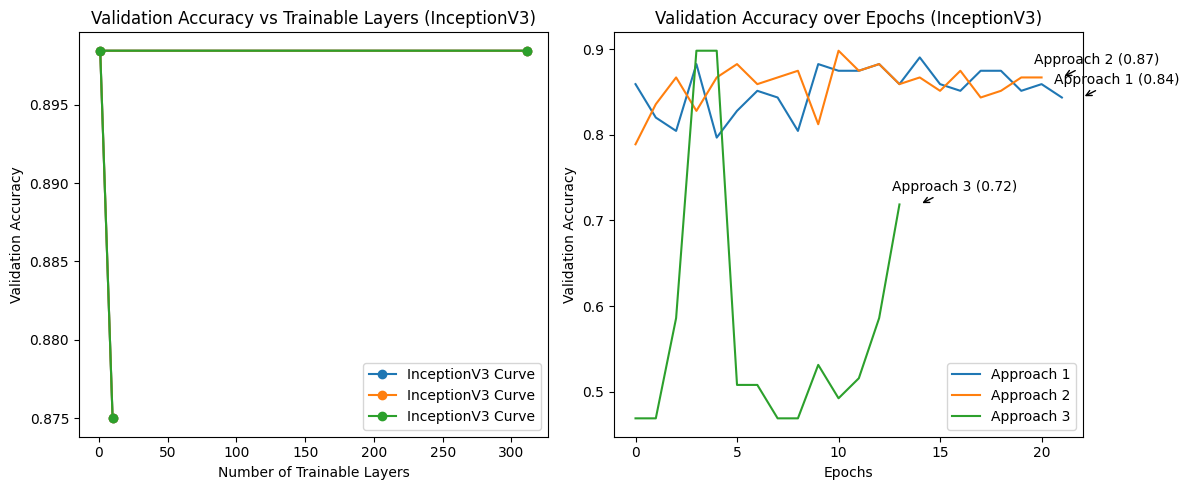

In [ ]:
results5 = fine_tune_model(base_model, "MobileNetV2", train, label_train, val, label_val)
results6 = fine_tune_model(base_model2, "ResNet50", train, label_train, val, label_val)
results7 = fine_tune_model(base_model3, "VGG16", train_ds, label_train, val_ds, label_val)
results8 = fine_tune_model(base_model4, "InceptionV3", train, label_train, val, label_val)

In [ ]:
#Reichel: might wanna use pandas here
def create_html_table(results_list):
    # Create the table header
    table_html = "<table border='1'><tr><th>Model Name</th><th>Time (s)</th><th>Parameters (Fixed, Trainable)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each list of results
    for results in results_list:
        # Iterate through each result in the list
        for result in results:
            model_name = result["Model Name"]
            time_for_training = result["Time for Training"]
            parameters = result["Parameters Numbers (Fixed, Trainable)"]
            validation_loss = result["Validation Loss"]
            validation_accuracy = result["Validation Accuracy"]

            # Add a row to the table
            table_html += f"<tr><td>{model_name}</td><td>{time_for_training}</td><td>{parameters}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

# Assuming you have results1, results2, ..., results7 as individual lists
results_list = [results1, results2, results3, results4, results5, results6, results7, results8]

# Create the HTML table
html_table = create_html_table(results_list)



In [ ]:
# Display the HTML table
display(HTML(html_table))


**Now We're gonna start with approach #2 (fine-tune only the output layer) and then create models with an increasing number of unfrozen layers for all available layers. This allows for a more granular exploration of fine-tuning**

In [ ]:
def fine_tune_resnet(pretrained_model, model_name, train_data, train_labels, val_data, val_labels):
    results = []
    trainable_layer_counts = []
    val_accuracies = []

    # Initial model
    base_model = Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    for unfrozen_layers in range(10, len(pretrained_model.layers), 10):
        model = clone_model(base_model)
        model.set_weights(base_model.get_weights())  # Copy weights from the base model

        reset_trainable(model, unfrozen_layers)  # Reset trainable layers in the current model

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time = time.time()
        history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(val_data, val_labels), callbacks=[lr_scheduler,early_stop], verbose=0)
        end_time = time.time()
        training_time = end_time - start_time
        loss, accuracy = model.evaluate(val_data, val_labels)

        trainable_layers = sum([1 for layer in model.layers[0].layers if layer.trainable])
        trainable_layer_counts.append(trainable_layers)
        val_accuracies.append(accuracy)

        results.append({
            "Model Name": f"{model_name}_frozen{unfrozen_layers}",
            "Time for Training": training_time,
            "Parameters Numbers (Fixed, Trainable)": (np.sum([np.prod(w.shape) for layer in model.layers[0].layers if not layer.trainable for w in layer.get_weights()]),
                                          np.sum([np.prod(w.shape) for layer in model.layers[0].layers if layer.trainable for w in layer.get_weights()])),


            "Validation Loss": loss,
            "Validation Accuracy": accuracy,
            "History": history
        })

    # Plot the graph
    plt.plot(trainable_layer_counts, val_accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Validation Accuracy vs Trainable Layers ({model_name})')
    plt.xlabel('Number of Trainable Layers')
    plt.ylabel('Validation Accuracy')

    for i, txt in enumerate(results):
        plt.annotate(f"Frozen Layers: {int(txt['Model Name'].split('_frozen')[1])}", (trainable_layer_counts[i], val_accuracies[i]))

    plt.show()

    return results

In [ ]:
from tensorflow.keras.models import clone_model

4/4 [==============================] - 0s 15ms/step - loss: 0.2255 - accuracy: 0.9141


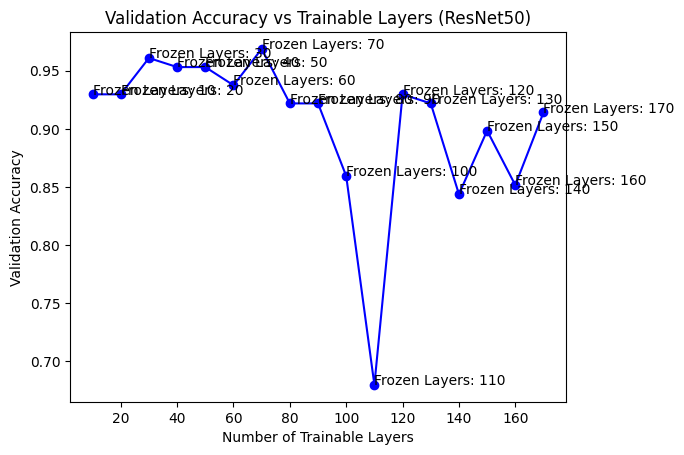

In [ ]:
resultsresn = fine_tune_resnet(base_model2, "ResNet50", train, label_train, val, label_val)

In [ ]:
#Reichel: might wanna use pandas here
def print_sorted_results(results_list):
    # Sort the results based on validation accuracy in descending order
    sorted_results = sorted(results_list, key=lambda x: x["Validation Accuracy"], reverse=True)

    # Display the header
    table_html = "<table border='1'><tr><th>Model Name</th><th>Time (s)</th><th>Parameters (Fixed, Trainable)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Display all results in descending order
    for result in sorted_results:
        model_name = result["Model Name"]
        time_for_training = result["Time for Training"]
        parameters = result["Parameters Numbers (Fixed, Trainable)"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{model_name}</td><td>{time_for_training}</td><td>{parameters}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    # Display the HTML table
    display(HTML(table_html))
print_sorted_results(resultsresn)


In [ ]:
def fine_tune_VGG(pretrained_model, model_name, train_data, train_labels, val_data, val_labels):
    results = []
    trainable_layer_counts = []
    val_accuracies = []

    # Initial model
    base_model = Sequential([
        pretrained_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    for unfrozen_layers in range(len(pretrained_model.layers)):
        model = clone_model(base_model)
        model.set_weights(base_model.get_weights())  # Copy weights from the base model

        reset_trainable(model, unfrozen_layers)  # Reset trainable layers in the current model

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        start_time = time.time()
        history = model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_data=(val_data, val_labels), callbacks=[lr_scheduler,early_stop], verbose=0)
        end_time = time.time()
        training_time = end_time - start_time
        loss, accuracy = model.evaluate(val_data, val_labels)

        trainable_layers = sum([1 for layer in model.layers[0].layers if layer.trainable])
        trainable_layer_counts.append(trainable_layers)
        val_accuracies.append(accuracy)

        results.append({
            "Model Name": f"{model_name}_unfrozen{unfrozen_layers}",
            "Time for Training": training_time,
            "Parameters Numbers (Fixed, Trainable)": (np.sum([np.prod(w.shape) for layer in model.layers[0].layers if not layer.trainable for w in layer.get_weights()]),
                                          np.sum([np.prod(w.shape) for layer in model.layers[0].layers if layer.trainable for w in layer.get_weights()])),

            "Validation Loss": loss,
            "Validation Accuracy": accuracy,
            "History": history
        })

    # Plot the graph
    plt.plot(trainable_layer_counts, val_accuracies, marker='o', linestyle='-', color='b')
    plt.title(f'Validation Accuracy vs Trainable Layers ({model_name})')
    plt.xlabel('Number of Trainable Layers')
    plt.ylabel('Validation Accuracy')

    for i, txt in enumerate(results):
        plt.annotate(f"Unfrozen Layers: {int(txt['Model Name'].split('_unfrozen')[1])}", (trainable_layer_counts[i], val_accuracies[i]))

    plt.show()

    return results

4/4 [==============================] - 0s 13ms/step - loss: 2.4263 - accuracy: 0.7266


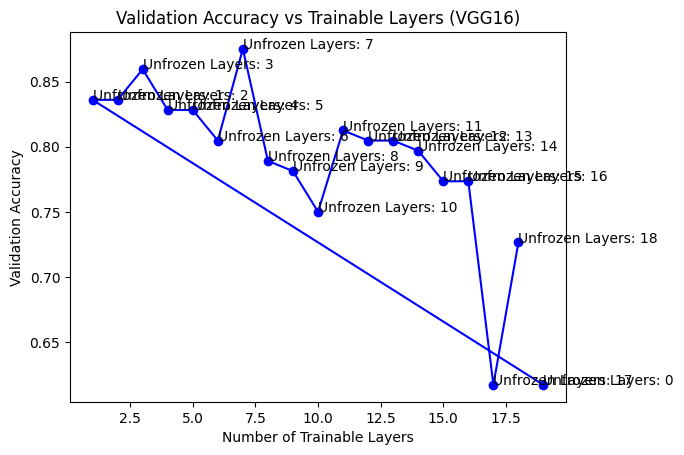

In [ ]:
resultsvgg = fine_tune_VGG(base_model3, "VGG16", train_ds, label_train, val_ds, label_val)

In [ ]:
print_sorted_results(resultsvgg)


# Now we are gonna experince it with different weight initializations
#
#

Training and evaluating Model 1 with {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None} initialization:
Epoch 1/100
33/33 [==============================] - 5s 60ms/step - loss: 0.6932 - accuracy: 0.5093 - val_loss: 0.6933 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 18ms/step - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6934 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5131 - val_loss: 0.6935 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5131 - val_loss: 0.6937 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 0.6930 - accuracy: 0.5131 - val_loss: 0.6937 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 1s 1

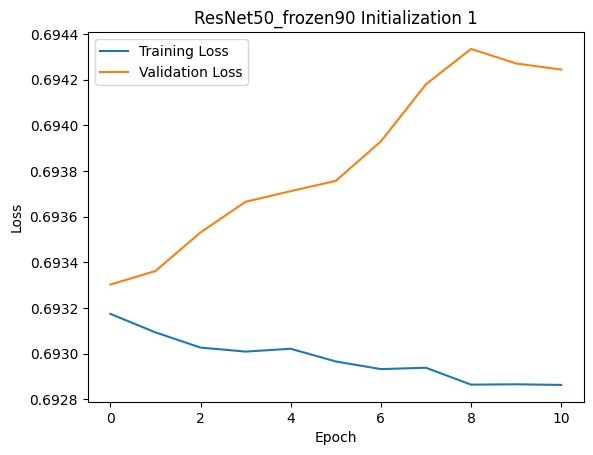

Training and evaluating Model 2 with {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None} initialization:
Epoch 1/100
33/33 [==============================] - 5s 58ms/step - loss: 0.0595 - accuracy: 0.9825 - val_loss: 0.3005 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0250 - accuracy: 0.9951 - val_loss: 0.5812 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 0.1915 - accuracy: 0.9971 - val_loss: 0.3731 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.4513 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 4.4031e-05 - accuracy: 1.0000 - val_loss: 0.4932 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 6/100
33/33 [==============================] - 

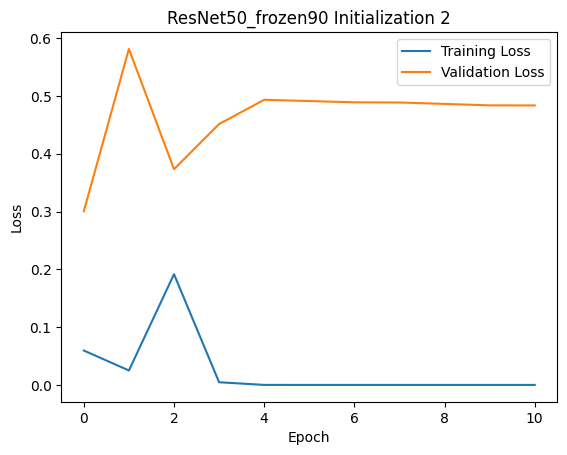

Training and evaluating Model 3 with {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None} initialization:
Epoch 1/100
33/33 [==============================] - 6s 62ms/step - loss: 0.2667 - accuracy: 0.9737 - val_loss: 0.4698 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0792 - accuracy: 0.9990 - val_loss: 0.4513 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.4484 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 6.6257e-04 - accuracy: 1.0000 - val_loss: 0.5006 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 7.2769e-05 - accuracy: 1.0000 - val_loss: 0.5072 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 6/100
33/33 [==============================

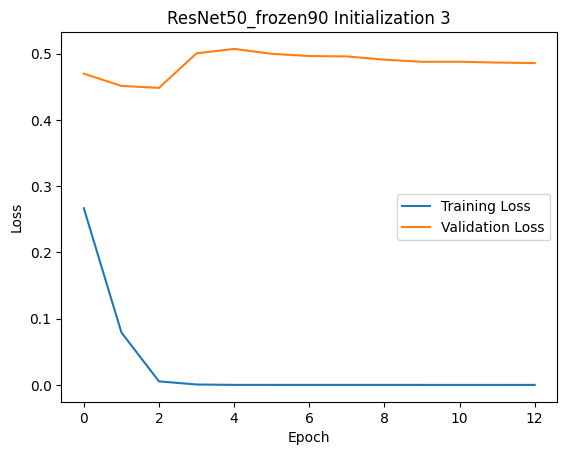

Training and evaluating Model 4 with {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None} initialization:
Epoch 1/100
33/33 [==============================] - 5s 58ms/step - loss: 0.2054 - accuracy: 0.9796 - val_loss: 0.2126 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.3159 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 5.1363e-05 - accuracy: 1.0000 - val_loss: 0.3141 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 3.8331e-05 - accuracy: 1.0000 - val_loss: 0.3100 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 2.9856e-05 - accuracy: 1.0000 - val_loss: 0.2996 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 6/100
33/33 [==========================

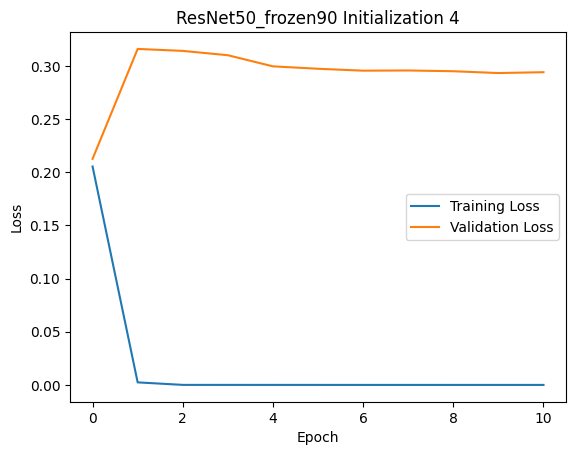

Training and evaluating Model 5 with {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None} initialization:
Epoch 1/100
33/33 [==============================] - 5s 59ms/step - loss: 0.0469 - accuracy: 0.9873 - val_loss: 0.3942 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.3345 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.4382 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 4/100
33/33 [==============================] - 1s 19ms/step - loss: 4.6467e-05 - accuracy: 1.0000 - val_loss: 0.4322 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 2.2770e-05 - accuracy: 1.0000 - val_loss: 0.3964 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 6/100
33/33 [==============================

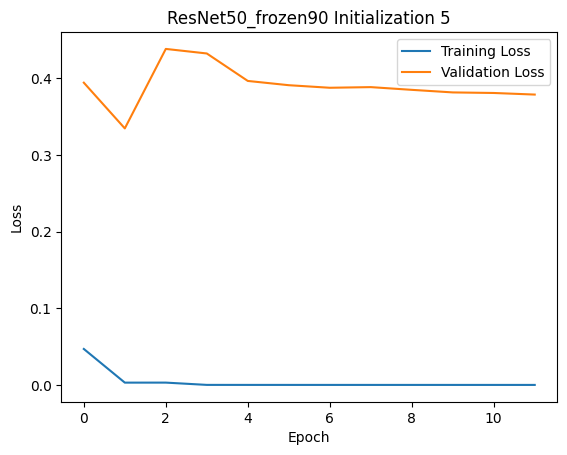

In [ ]:
# Reset trainable status of base_model2
reseet_trainable(base_model2)

for layer in base_model2.layers[:-1]:
    layer.trainable = False

# Zero Initialization
fine_tuned_model_resnet_zeros = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='zeros'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Random Initialization
fine_tuned_model_resnet_random = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='random_normal'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Xavier/Glorot Initialization
fine_tuned_model_resnet_xavier = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='glorot_normal'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# He Initialization
fine_tuned_model_resnet_he = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# LeCun Initialization
fine_tuned_model_resnet_lecun = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_initializer='lecun_normal'),
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile each model
models_to_compile_resnet = [fine_tuned_model_resnet_zeros, fine_tuned_model_resnet_random,
                            fine_tuned_model_resnet_xavier, fine_tuned_model_resnet_he, fine_tuned_model_resnet_lecun]

for model in models_to_compile_resnet:
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_results = []
# Iterate through each model
for i, model in enumerate(models_to_compile_resnet):
    print(f"Training and evaluating Model {i + 1} with {model.layers[-1].get_config()['kernel_initializer']} initialization:")

    # Train the model
    start_time = time.time()
    history = model.fit(train, label_train , epochs=100, batch_size=32, validation_data=(val, label_val), callbacks=[lr_scheduler,early_stop], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    eval_result = model.evaluate(val, label_val)
    validation_loss = eval_result[0]
    validation_accuracy = eval_result[1] * 100

    # Append results to the list
    model_results.append({
        "Model Name": f"Model{i + 1}_{model.layers[-1].get_config()['kernel_initializer']}",
        "Time for Training": training_time,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
    })

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'ResNet50_frozen90 Initialization {i + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def create_html_table_for_models(model_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>Model Name</th><th>Time (s)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each model result
    for result in model_results:
        model_name = result["Model Name"]
        time_for_training = result["Time for Training"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{model_name}</td><td>{time_for_training}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

html_table_models = create_html_table_for_models(model_results)

display(HTML(html_table_models))


# The Best Weight initializations is Default Initialization
**Now we are gonna experince further Hyperparameter tuning for learning rate and adding different regularization layers like dropout, L1 and L2**

In [ ]:
def build_model_lr(learning_rate):


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Training and evaluating Model with Learning Rate: 0.1
Epoch 1/100
26/26 [==============================] - 6s 87ms/step - loss: 308.7923 - accuracy: 0.9501 - val_loss: 7.4357 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 12.7611 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 13.2384 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 4.2461e-27 - accuracy: 1.0000 - val_loss: 13.2753 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 6.0915e-26 - accuracy: 1.0000 - val_loss: 13.2781 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 5.0227e-25 - accuracy: 1.0000 - val_loss: 13.2783 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step -

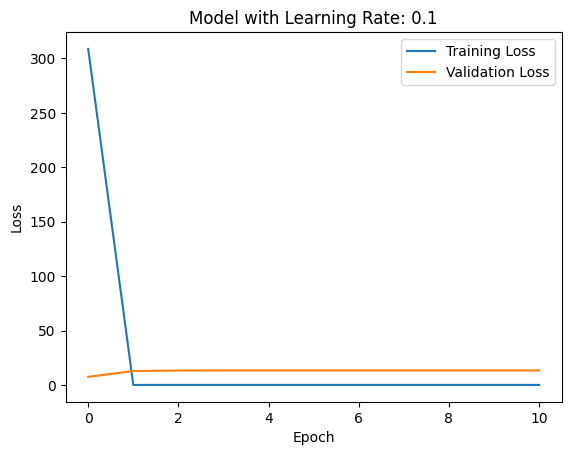

Training and evaluating Model with Learning Rate: 0.5
Epoch 1/100
26/26 [==============================] - 6s 82ms/step - loss: 1458.0800 - accuracy: 0.9513 - val_loss: 19.8361 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 769.5330 - accuracy: 0.9963 - val_loss: 322.1598 - val_accuracy: 0.9903
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 0.4759 - accuracy: 0.9988 - val_loss: 170.6036 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 161.9568 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 161.3121 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 161.2655 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step 

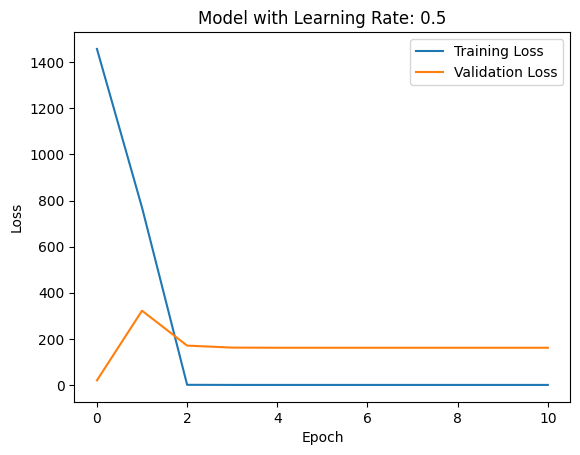

Training and evaluating Model with Learning Rate: 0.01
Epoch 1/100
26/26 [==============================] - 6s 77ms/step - loss: 1.4740 - accuracy: 0.9464 - val_loss: 2.0605e-17 - val_accuracy: 1.0000
Epoch 2/100
26/26 [==============================] - 1s 21ms/step - loss: 4.9305 - accuracy: 0.9963 - val_loss: 0.2964 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 3.4343e-20 - accuracy: 1.0000 - val_loss: 0.5354 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 1.0740e-11 - accuracy: 1.0000 - val_loss: 0.5518 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 2.3310e-11 - accuracy: 1.0000 - val_loss: 0.5530 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 4.3044e-11 - accuracy: 1.0000 - val_loss: 0.5531 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss:

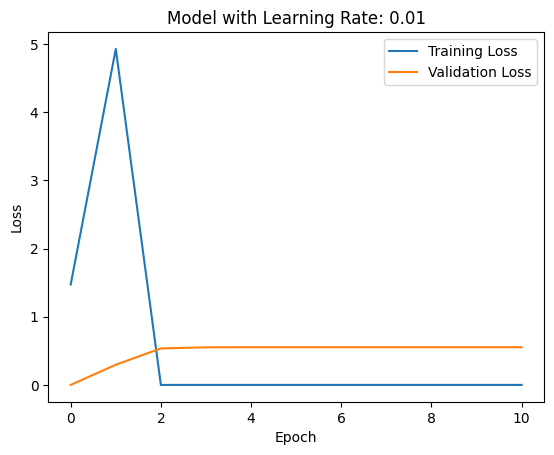

Training and evaluating Model with Learning Rate: 0.05
Epoch 1/100
26/26 [==============================] - 6s 77ms/step - loss: 17.8026 - accuracy: 0.9756 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 11.1063 - accuracy: 0.9951 - val_loss: 6.0085 - val_accuracy: 0.9903
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5096 - accuracy: 0.9988 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 20m

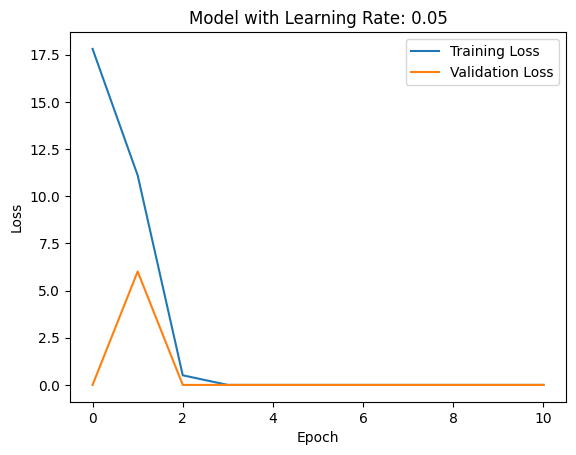

Training and evaluating Model with Learning Rate: 0.001
Epoch 1/100
26/26 [==============================] - 6s 78ms/step - loss: 0.0400 - accuracy: 0.9793 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 3.5505e-05 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 1.9617e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 1.4247e-05 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 1.1048e-05 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 23ms/step - loss: 7.6296e-06 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 23ms/step - loss

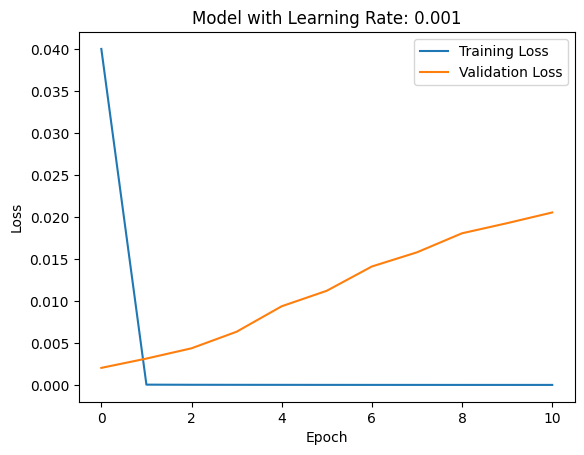

Training and evaluating Model with Learning Rate: 0.005
Epoch 1/100
26/26 [==============================] - 6s 76ms/step - loss: 0.1883 - accuracy: 0.9817 - val_loss: 0.0426 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.3930 - accuracy: 0.9939 - val_loss: 9.9631e-11 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 0.3143 - accuracy: 0.9988 - val_loss: 0.0311 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 4.4915e-11 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 4.3279e-11 - accuracy: 1.0000 - val_loss: 0.0515 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 4.2704e-11 - accuracy: 1.0000 - val_loss: 0.0516 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 4.

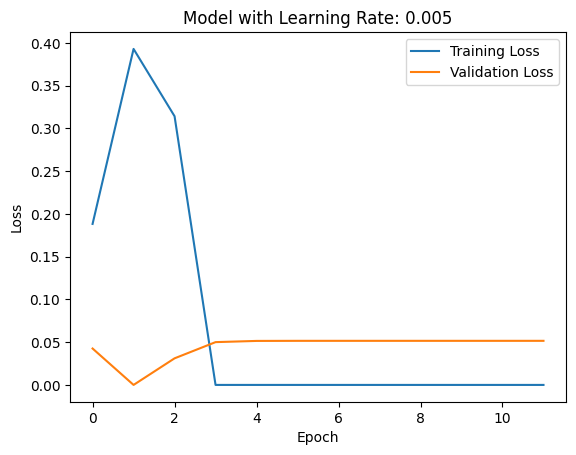

Training and evaluating Model with Learning Rate: 0.0001
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 0.1616 - accuracy: 0.9306 - val_loss: 0.0106 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 28ms/step - loss: 0.0095 - accuracy: 0.9988 - val_loss: 0.0087 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0015 - accuracy

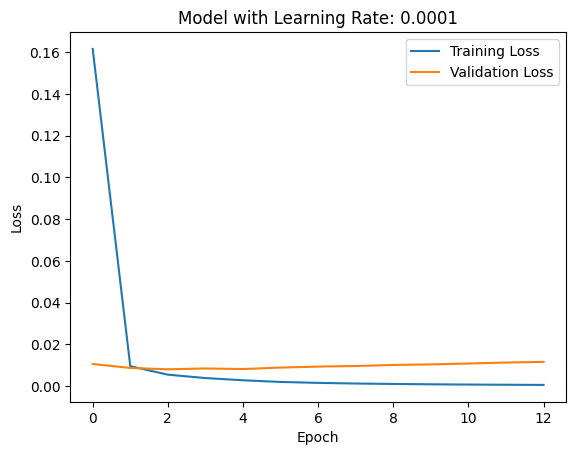

Training and evaluating Model with Learning Rate: 5e-05
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 0.1274 - accuracy: 0.9525 - val_loss: 0.0150 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0109 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0028 - accuracy:

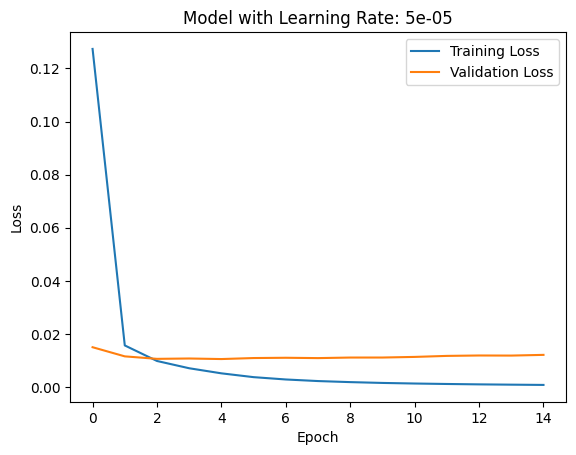

In [ ]:
lr_results = []
# Define the learning rates to search
learning_rates = [0.1, 0.5, 0.01, 0.05, 0.001, 0.005, 0.0001, 0.00005]

for lr in learning_rates:
    K.clear_session()  # Clear the TensorFlow session to free up resources
    model = build_model_lr(lr)

    print(f"Training and evaluating Model with Learning Rate: {lr}")

    # Train the model
    start_time = time.time()
    history = model.fit(train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    eval_result = model.evaluate(val, label_val)
    validation_loss = eval_result[0]
    validation_accuracy = eval_result[1] * 100

    # Append results to the list
    lr_results.append({
        "Learning Rate": lr,
        "Time for Training": training_time,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
    })

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model with Learning Rate: {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def create_html_table_for_learning_rates(lr_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>Learning Rate</th><th>Time (s)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each learning rate result
    for result in lr_results:
        learning_rate = result["Learning Rate"]
        time_for_training = result["Time for Training"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{learning_rate}</td><td>{time_for_training}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

# Create the HTML table for learning rates
html_table_lr = create_html_table_for_learning_rates(lr_results)

# Display the HTML table
display(HTML(html_table_lr))


In [ ]:
def build_model_DO(dropout_rate):


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Training and evaluating Model with Dropout Rate: 0.1
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 0.2451 - accuracy: 0.9659 - val_loss: 0.0535 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 3.8807e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 27ms/step - loss: 1.8203e-05 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 1.2592e-05 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 1.3424e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 6.2347e-06 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 7

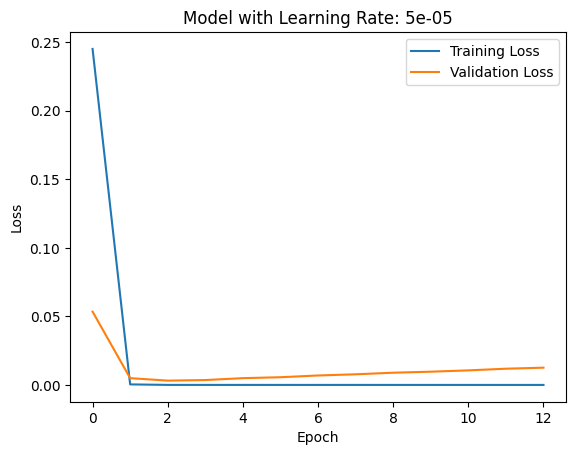

Training and evaluating Model with Dropout Rate: 0.2
Epoch 1/100
26/26 [==============================] - 10s 84ms/step - loss: 0.1106 - accuracy: 0.9659 - val_loss: 0.0357 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 25ms/step - loss: 6.7693e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0102 - accuracy: 0.9988 - val_loss: 0.0323 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 0.0147 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 26ms/step - loss: 3.6353e-05 - accuracy: 1.0000 - val_loss: 5.9738e-04 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 3.2768e-05 - accuracy: 1.0000 - val_loss: 5.0666e-04 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 

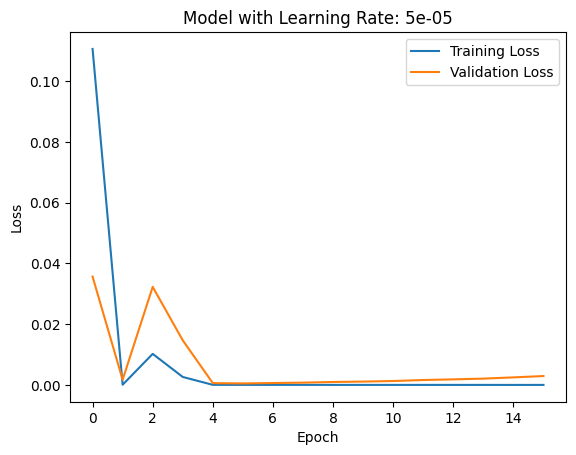

Training and evaluating Model with Dropout Rate: 0.3
Epoch 1/100
26/26 [==============================] - 6s 84ms/step - loss: 0.1441 - accuracy: 0.9817 - val_loss: 0.0219 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0021 - accuracy: 0.9988 - val_loss: 0.0334 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 2.7329e-05 - accuracy: 1.0000 - val_loss: 2.6242e-04 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 3.4439e-05 - accuracy: 1.0000 - val_loss: 2.7850e-04 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 2.5245e-05 - accuracy: 1.0000 - val_loss: 3.2614e-04 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - los

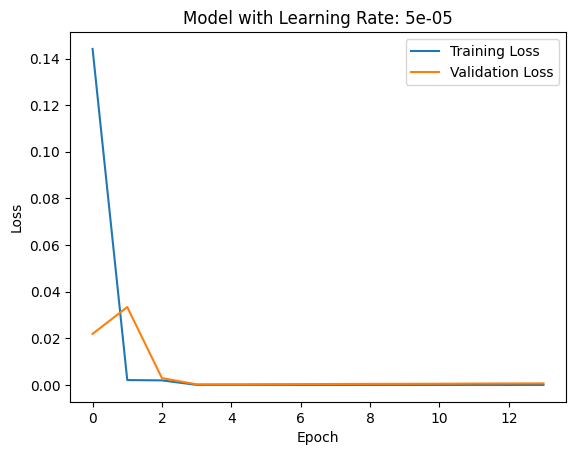

Training and evaluating Model with Dropout Rate: 0.4
Epoch 1/100
26/26 [==============================] - 6s 79ms/step - loss: 0.1903 - accuracy: 0.9744 - val_loss: 0.0317 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 8.7473e-05 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0359 - accuracy: 0.9963 - val_loss: 0.0057 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0316 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 2.1198e-05 - accuracy: 1.0000 - val_loss: 0.0211 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 6.7737e-06 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 6.1410e-0

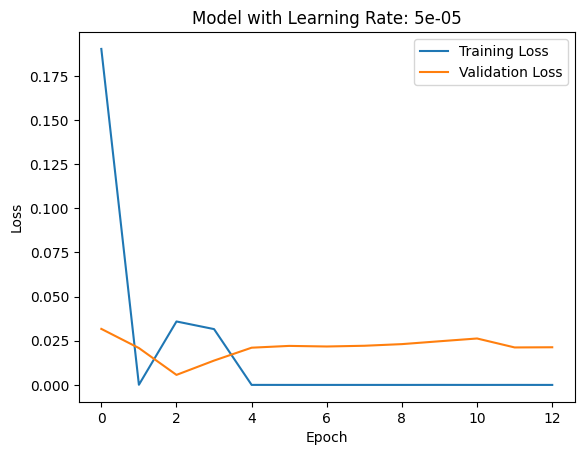

Training and evaluating Model with Dropout Rate: 0.5
Epoch 1/100
26/26 [==============================] - 6s 78ms/step - loss: 0.3509 - accuracy: 0.9732 - val_loss: 0.0208 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 20ms/step - loss: 4.9277e-04 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 20ms/step - loss: 2.9423e-05 - accuracy: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 29ms/step - loss: 2.1358e-04 - accuracy: 1.0000 - val_loss: 0.0107 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0777 - accuracy: 0.9976 - val_loss: 0.0256 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 1.7071e-05 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 1.624

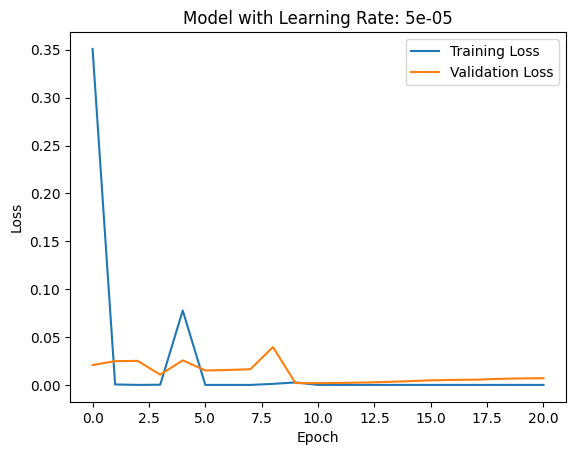

In [ ]:
dropout_results = []
# Define the learning rates to search
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for DO in dropout_rates:
    K.clear_session()  # Clear the TensorFlow session to free up resources
    model = build_model_DO(DO)

    print(f"Training and evaluating Model with Dropout Rate: {DO}")

    # Train the model
    start_time = time.time()
    history = model.fit(train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    eval_result = model.evaluate(val, label_val)
    validation_loss = eval_result[0]
    validation_accuracy = eval_result[1] * 100

    # Append results to the list
    dropout_results.append({
        "Dropout Rate": DO,
        "Time for Training": training_time,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
    })

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model with Learning Rate: {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def create_html_table_for_dropout_rates(dropout_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>Dropout Rate</th><th>Time (s)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each learning rate result
    for result in dropout_results:
        Dropout_rate = result["Dropout Rate"]
        time_for_training = result["Time for Training"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{Dropout_rate}</td><td>{time_for_training}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

# Create the HTML table for learning rates
html_table_DO = create_html_table_for_dropout_rates(dropout_results)

# Display the HTML table
display(HTML(html_table_DO))


In [ ]:
def build_model_L1(l1_regularization):


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l1(l1_regularization)),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Training and evaluating Model with L1 Regularization Value: 1e-05
Epoch 1/100
26/26 [==============================] - 6s 78ms/step - loss: 0.3018 - accuracy: 0.9817 - val_loss: 0.1538 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.1111 - accuracy: 1.0000 - val_loss: 0.1056 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.1026 - accuracy: 1.0000 - val_loss: 0.0996 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0973 - accuracy: 1.0000 - val_loss: 0.0950 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0930 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0892 - accuracy: 1.0000 - val_loss: 0.0875 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0858 -

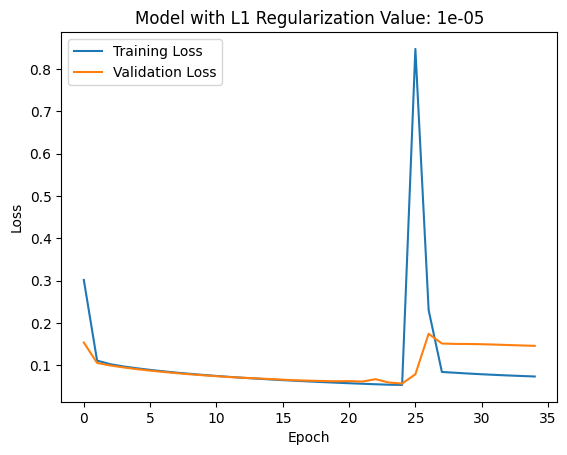

Training and evaluating Model with L1 Regularization Value: 0.0001
Epoch 1/100
26/26 [==============================] - 6s 78ms/step - loss: 1.3977 - accuracy: 0.9817 - val_loss: 1.0873 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.9437 - accuracy: 0.9988 - val_loss: 0.8516 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.7976 - accuracy: 1.0000 - val_loss: 0.7460 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 27ms/step - loss: 0.7077 - accuracy: 1.0000 - val_loss: 0.6704 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 26ms/step - loss: 0.6397 - accuracy: 1.0000 - val_loss: 0.6102 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 0.6701 - accuracy: 0.9903 - val_loss: 0.6283 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 0.9528 

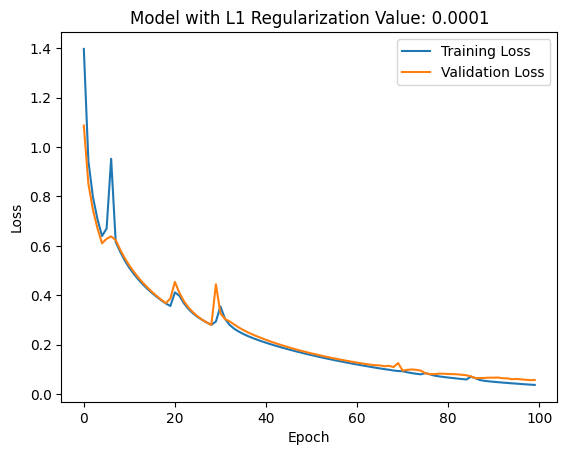

Training and evaluating Model with L1 Regularization Value: 0.001
Epoch 1/100
26/26 [==============================] - 6s 76ms/step - loss: 10.7421 - accuracy: 0.9829 - val_loss: 7.9113 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 6.1502 - accuracy: 0.9976 - val_loss: 4.8664 - val_accuracy: 0.9903
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 4.1534 - accuracy: 0.9988 - val_loss: 3.5435 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 3.1388 - accuracy: 1.0000 - val_loss: 2.7806 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 2.5158 - accuracy: 1.0000 - val_loss: 2.2683 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 2.0799 - accuracy: 1.0000 - val_loss: 1.8961 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 2.2198 

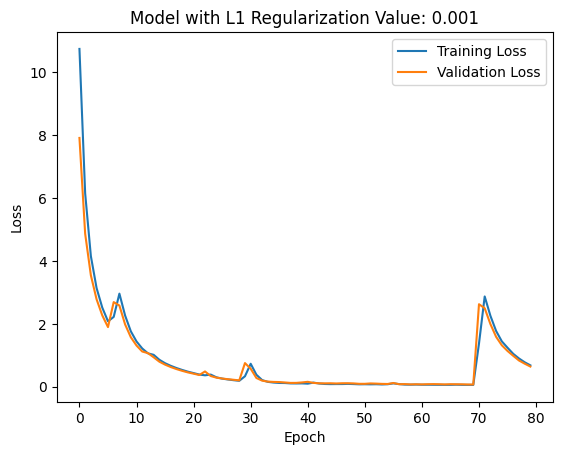

Training and evaluating Model with L1 Regularization Value: 0.01
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 94.7473 - accuracy: 0.9683 - val_loss: 55.9241 - val_accuracy: 0.9951
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 34.9722 - accuracy: 0.9988 - val_loss: 20.5734 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 25ms/step - loss: 15.3697 - accuracy: 1.0000 - val_loss: 11.1175 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 9.0310 - accuracy: 0.9963 - val_loss: 7.0430 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 5.7708 - accuracy: 1.0000 - val_loss: 4.5674 - val_accuracy: 0.9854
Epoch 6/100
26/26 [==============================] - 1s 26ms/step - loss: 3.8896 - accuracy: 0.9951 - val_loss: 3.1160 - val_accuracy: 0.9757
Epoch 7/100
26/26 [==============================] - 1s 25ms/step - loss: 2.8

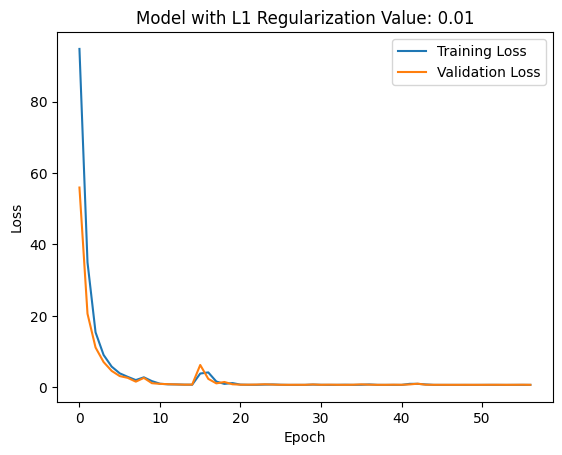

In [ ]:
# List to store results for each L1 regularization value
l1_results = []

# Define the L1 regularization rates to search
l1_regularization_values = [1e-5, 1e-4, 1e-3, 1e-2]

# Iterate over L1 regularization rates and build models
for l1_regularization_value in l1_regularization_values:
    K.clear_session()  # Clear the TensorFlow session to free up resources
    model = build_model_L1(l1_regularization_value)

    print(f"Training and evaluating Model with L1 Regularization Value: {l1_regularization_value}")

    # Train the model
    start_time = time.time()
    history = model.fit(train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    eval_result = model.evaluate(val, label_val)
    validation_loss = eval_result[0]
    validation_accuracy = eval_result[1] * 100

    # Append results to the list
    l1_results.append({
        "L1 Regularization Value": l1_regularization_value,
        "Time for Training": training_time,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
    })

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model with L1 Regularization Value: {l1_regularization_value}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def create_html_table_for_l1_regularization(l1_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>L1 Regularization Value</th><th>Time (s)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each L1 regularization result
    for result in l1_results:
        l1_regularization_value = result["L1 Regularization Value"]
        time_for_training = result["Time for Training"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{l1_regularization_value}</td><td>{time_for_training}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

html_table_l1 = create_html_table_for_l1_regularization(l1_results)

# Display the HTML table
display(HTML(html_table_l1))


In [ ]:
def build_model_L2(l2_regularization):


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=l2(l2_regularization)),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Training and evaluating Model with L2 Regularization Value: 1e-05
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 0.1601 - accuracy: 0.9793 - val_loss: 0.0386 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0075 - accuracy: 0.9988 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 3/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0041 -

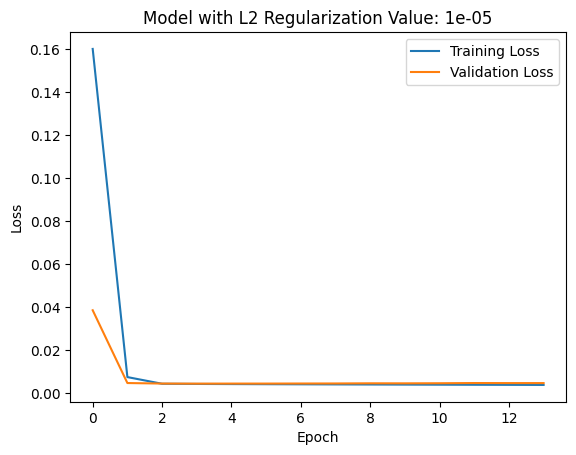

Training and evaluating Model with L2 Regularization Value: 0.0001
Epoch 1/100
26/26 [==============================] - 6s 73ms/step - loss: 0.3949 - accuracy: 0.9744 - val_loss: 0.0701 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0437 - accuracy: 0.9988 - val_loss: 0.0488 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0372 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.0460 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0343 

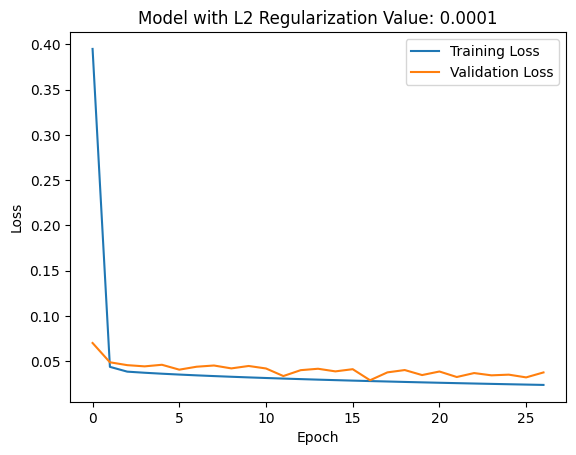

Training and evaluating Model with L2 Regularization Value: 0.001
Epoch 1/100
26/26 [==============================] - 6s 73ms/step - loss: 0.4231 - accuracy: 0.9793 - val_loss: 0.3224 - val_accuracy: 1.0000
Epoch 2/100
26/26 [==============================] - 1s 27ms/step - loss: 0.2805 - accuracy: 1.0000 - val_loss: 0.2512 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 27ms/step - loss: 0.2251 - accuracy: 1.0000 - val_loss: 0.2134 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 0.1902 - accuracy: 1.0000 - val_loss: 0.1852 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 0.1645 - accuracy: 1.0000 - val_loss: 0.1676 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 0.1445 - accuracy: 1.0000 - val_loss: 0.1383 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 26ms/step - loss: 0.1283 -

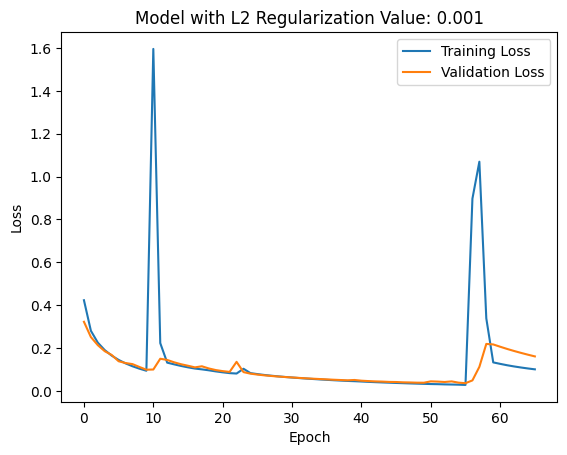

Training and evaluating Model with L2 Regularization Value: 0.01
Epoch 1/100
26/26 [==============================] - 6s 75ms/step - loss: 3.5102 - accuracy: 0.9951 - val_loss: 2.5255 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 25ms/step - loss: 1.9821 - accuracy: 0.9976 - val_loss: 1.6262 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 25ms/step - loss: 1.3984 - accuracy: 1.0000 - val_loss: 1.2256 - val_accuracy: 0.9951
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 1.0843 - accuracy: 1.0000 - val_loss: 0.9731 - val_accuracy: 0.9951
Epoch 5/100
26/26 [==============================] - 1s 25ms/step - loss: 0.8740 - accuracy: 1.0000 - val_loss: 0.7992 - val_accuracy: 0.9951
Epoch 6/100
26/26 [==============================] - 1s 25ms/step - loss: 0.7213 - accuracy: 1.0000 - val_loss: 0.6688 - val_accuracy: 0.9951
Epoch 7/100
26/26 [==============================] - 1s 26ms/step - loss: 0.6048 - 

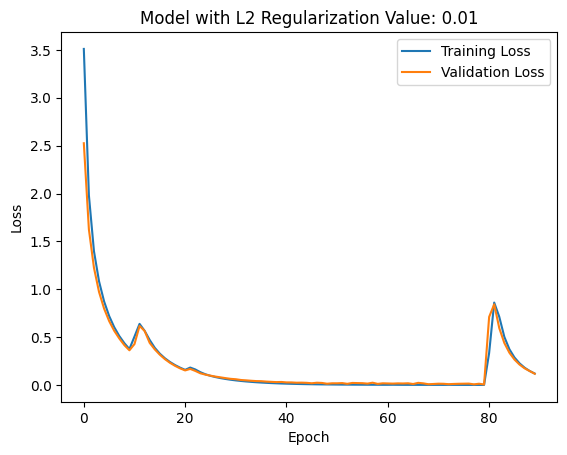

In [ ]:
l2_results = []

# Define the L2 regularization rates to search
l2_regularization_values = [1e-5, 1e-4, 1e-3, 1e-2]

# Iterate over L2 regularization rates and build models
for l2_regularization_value in l2_regularization_values:
    K.clear_session()  # Clear the TensorFlow session to free up resources
    model = build_model_L2(l2_regularization_value)

    print(f"Training and evaluating Model with L2 Regularization Value: {l2_regularization_value}")

    # Train the model
    start_time = time.time()
    history = model.fit(train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate the model
    eval_result = model.evaluate(val, label_val)
    validation_loss = eval_result[0]
    validation_accuracy = eval_result[1] * 100

    # Append results to the list
    l2_results.append({
        "L2 Regularization Value": l2_regularization_value,
        "Time for Training": training_time,
        "Validation Loss": validation_loss,
        "Validation Accuracy": validation_accuracy,
    })

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model with L2 Regularization Value: {l2_regularization_value}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def create_html_table_for_l2_regularization(l2_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>L2 Regularization Value</th><th>Time (s)</th><th>Validation Loss</th><th>Validation Accuracy</th></tr>"

    # Iterate through each L2 regularization result
    for result in l2_results:
        l2_regularization_value = result["L2 Regularization Value"]
        time_for_training = result["Time for Training"]
        validation_loss = result["Validation Loss"]
        validation_accuracy = result["Validation Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{l2_regularization_value}</td><td>{time_for_training}</td><td>{validation_loss}</td><td>{validation_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

html_table_l2 = create_html_table_for_l2_regularization(l2_results)

# Display the HTML table
display(HTML(html_table_l2))


# Now we are gonna expirence adding augmentation to the training data and adding batch normalization

In [ ]:
def build_n_model():


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train)


In [ ]:
model_aug = build_n_model()

history = model_aug.fit(
    datagen.flow(train, label_train),
    epochs=10, batch_size=32, callbacks=[early_stop], verbose=1)

# Evaluate on test set
val_loss, val_acc = model_aug.evaluate(val, label_val)
print(f'val Loss: {val_loss}, val Accuracy: {val_acc}')



Epoch 1/10
33/33 [==============================] - 5s 54ms/step - loss: 0.1788 - accuracy: 0.9445
Epoch 2/10
33/33 [==============================] - 2s 57ms/step - loss: 0.4230 - accuracy: 0.9581
Epoch 3/10
33/33 [==============================] - 2s 55ms/step - loss: 0.1600 - accuracy: 0.9591
Epoch 4/10
33/33 [==============================] - 2s 55ms/step - loss: 0.2359 - accuracy: 0.9620
Epoch 5/10
33/33 [==============================] - 2s 56ms/step - loss: 0.1271 - accuracy: 0.9766
Epoch 6/10
33/33 [==============================] - 2s 56ms/step - loss: 0.3669 - accuracy: 0.9727
Epoch 7/10
33/33 [==============================] - 2s 55ms/step - loss: 0.1754 - accuracy: 0.9786
Epoch 8/10
33/33 [==============================] - 2s 57ms/step - loss: 0.0711 - accuracy: 0.9766
Epoch 9/10
33/33 [==============================] - 2s 58ms/step - loss: 0.0624 - accuracy: 0.9805
Epoch 10/10
4/4 [==============================] - 1s 16ms/step - loss: 1.0664 - accuracy: 0.6172
val Loss: 1

In [ ]:
def build_BN_model():


    reseet_trainable(base_model2)

    model = Sequential([
        base_model2,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])


    for layer in base_model2.layers[:-1]:
        layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


Epoch 1/100
26/26 [==============================] - 7s 79ms/step - loss: 0.0447 - accuracy: 0.9781 - val_loss: 0.0196 - val_accuracy: 0.9903
Epoch 2/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0129 - val_accuracy: 0.9951
Epoch 3/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9903
Epoch 4/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 5/100
26/26 [==============================] - 1s 26ms/step - loss: 4.7744e-04 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 6/100
26/26 [==============================] - 1s 26ms/step - loss: 2.4538e-04 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 7/100
26/26 [==============================] - 1s 21ms/step - loss: 7.8795e-04 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 0

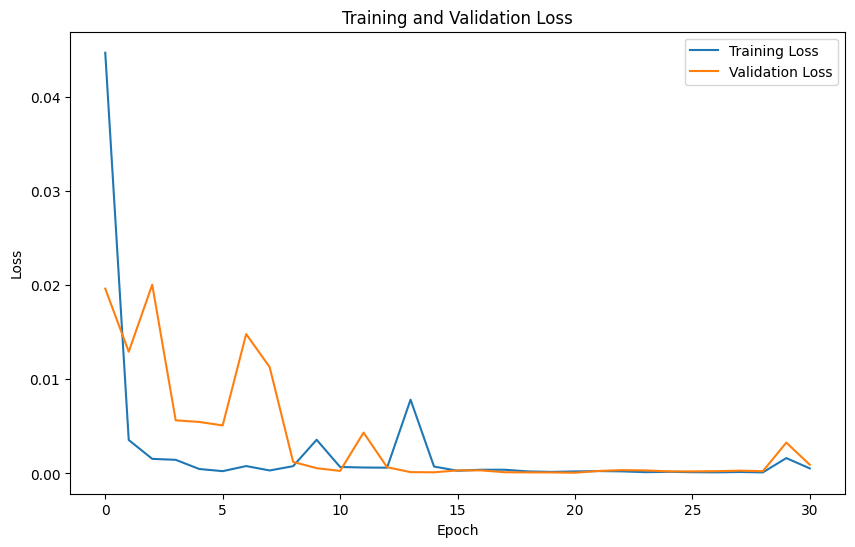

In [ ]:
model_BN = build_BN_model()

history = model_BN.fit(train, label_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)


# Evaluate on test set
val_loss, val_acc = model_BN.evaluate(val, label_val)
print(f'val Loss: {val_loss}, val Accuracy: {val_acc}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')

# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model_aug_BN = build_BN_model()

history = model_aug_BN.fit(
    datagen.flow(train, label_train),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop],
)

# Evaluate on test set
val_loss, val_acc = model_aug_BN.evaluate(val, label_val)
print(f'val Loss: {val_loss}, val Accuracy: {val_acc}')


Epoch 1/10
33/33 [==============================] - 6s 52ms/step - loss: 0.2266 - accuracy: 0.9094
Epoch 2/10
33/33 [==============================] - 2s 59ms/step - loss: 0.1449 - accuracy: 0.9562
Epoch 3/10
33/33 [==============================] - 2s 56ms/step - loss: 0.1077 - accuracy: 0.9640
Epoch 4/10
33/33 [==============================] - 2s 55ms/step - loss: 0.1304 - accuracy: 0.9542
Epoch 5/10
33/33 [==============================] - 2s 55ms/step - loss: 0.0973 - accuracy: 0.9659
Epoch 6/10
33/33 [==============================] - 2s 56ms/step - loss: 0.0875 - accuracy: 0.9620
Epoch 7/10
33/33 [==============================] - 2s 54ms/step - loss: 0.0895 - accuracy: 0.9718
Epoch 8/10
33/33 [==============================] - 2s 55ms/step - loss: 0.1239 - accuracy: 0.9523
Epoch 9/10
33/33 [==============================] - 2s 55ms/step - loss: 0.1231 - accuracy: 0.9523
Epoch 10/10
4/4 [==============================] - 1s 16ms/step - loss: 0.7220 - accuracy: 0.6953
val Loss: 0

# We have now our best performing model so we are gonna train it on the whole training data and compare it to the base model

In [ ]:
combined_x = np.concatenate((train, val), axis=0)
combined_y = np.concatenate((label_train, label_val), axis=0)


In [ ]:
BaseModel = models.Sequential(
    [
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(75, 75, 3)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ]
)

BaseModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
BestModel = Sequential([
        resnet,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


for layer in base_model2.layers[:-1]:
    layer.trainable = False

BestModel.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Train and evaluate BaseModel
Base_history = BaseModel.fit(combined_x, combined_y, epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
eval_base = BaseModel.evaluate(test, label_test)
test_loss_base = eval_base[0]
test_accuracy_base = eval_base[1] * 100

# Train and evaluate BestModel
Best_history = BestModel.fit(combined_x, combined_y, epochs=30, batch_size=32, callbacks=[lr_scheduler], verbose=0)
eval_best = BestModel.evaluate(test, label_test)
test_loss_best = eval_best[0]
test_accuracy_best = eval_best[1] * 100


4/4 [==============================] - 1s 17ms/step - loss: 0.0012 - accuracy: 1.0000


In [ ]:
# Create results dictionary for comparison
model_comparison_results = [
    {
        "Model Name": "BaseModel",
        "Test Loss": test_loss_base,
        "Test Accuracy": test_accuracy_base,
    },
    {
        "Model Name": "BestModel",
        "Test Loss": test_loss_best,
        "Test Accuracy": test_accuracy_best,
    }
]


In [ ]:
def create_html_table_for_model_comparison(model_results):
    # Create the table header
    table_html = "<table border='1'><tr><th>Model Name</th><th>Test Loss</th><th>Test Accuracy</th></tr>"
    # Iterate through each model result
    for result in model_results:
        model_name = result["Model Name"]
        test_loss = result["Test Loss"]
        test_accuracy = result["Test Accuracy"]

        # Add a row to the table
        table_html += f"<tr><td>{model_name}</td><td>{test_loss}</td><td>{test_accuracy}</td></tr>"

    # Close the table tag
    table_html += "</table>"

    return table_html

html_table_comparison = create_html_table_for_model_comparison(model_comparison_results)

# Display the HTML table
display(HTML(html_table_comparison))
